# Detecting the presence of infectious diseases in chest X-Ray images <a name="start"></a>
CoronaHack -Chest X-Ray-Dataset On Kaggle : 
https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset

# Table of content

1. [Imports](#imports)
2. [Getting the Data](#data)
3. [Variable analysis and cleaning](#analysis)
	1. [Variable X_ray_image_name](#var_xray)
	2. [Variable Label](#var_label)
	3. [Variable Dataset_type](#var_type)
	4. [Label_2_Virus_category and Label_1_Virus_category](#var_virus)
4. [First classification glimpse](#glimpse)
5. [Transforming the Data](#transform)
6. [Desiging a model](#design)
	1. [First benches](#bench)
		1. [Not noised](#bench_1)
		2. [Adding noise](#bench_2)
		3. [Since we are working with an unbalanced dataset...](#unbalance)
			1. [Why accuracy is not always a good metrics choice](#accuracy)
			2. [Which metrics can we use, then ?](#metrics)
			3. [We can save accuracy though...](#save)
		4. [Applying class_weights to the model](#weights)
			1. [With noise](#weights_1)
			2. [Without noise](#weights_2)
		5. [Noise vs no noise, weighted vs not weighted](#versus)
	2. [Choosing the number of subsampling blocks](#subs)
	3. [Choosing the kernel size](#kernel)
	4. [Choosing filters size](#filters)
	5. [Choosing the Dense layer size](#dense)
		1. [First pass](#pass_1)
		2. [Second pass](#pass_2)
	6. [Adding Batch normalization instead of MaxPooling](#batch)
	7. [Adding dropout](#dropout)
		1. [With batch normalization](#dropout_1)
		2. [Without batch normalization](#dropout_2)
	8. [Finalizing the model](#final)
		1. [Fitting](#fit)
		2. [Testing the model on test set](#test)
7. [Ensembling](#ensemble)
	1. [Ensemble of disparate models](#ensemble_1)
	2. [Ensemble of final models](#ensemble_2)
8. [Conclusion](#conclusion)

# Imports <a name="imports"></a>

In [135]:
# Related to direct calculations
import math
import random
from sklearn.utils import shuffle
import itertools
import numpy as np
# Related to visualisation
import pandas as pd
from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt
# Related to navigation and access
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Related to Machine Learning and metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, AvgPool2D, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, precision_score, recall_score

[Go back to the top](#start)

# Getting the Data <a name="data"></a>

The dataset can be downloaded here : https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset/download

You might need to be logged in Kaggle to access it.

In [136]:
meta_dataset = "Chest_xray_Corona_Metadata.csv"
image_dir = "images"
seed = 681814

In [137]:
original_data = pd.read_csv(meta_dataset)
original_data

Unnamed: 0            X_ray_image_name     Label Dataset_type  \
0              0           IM-0128-0001.jpeg    Normal        TRAIN   
1              1           IM-0127-0001.jpeg    Normal        TRAIN   
2              2           IM-0125-0001.jpeg    Normal        TRAIN   
3              3           IM-0122-0001.jpeg    Normal        TRAIN   
4              4           IM-0119-0001.jpeg    Normal        TRAIN   
...          ...                         ...       ...          ...   
5905        5928  person1637_virus_2834.jpeg  Pnemonia         TEST   
5906        5929  person1635_virus_2831.jpeg  Pnemonia         TEST   
5907        5930  person1634_virus_2830.jpeg  Pnemonia         TEST   
5908        5931  person1633_virus_2829.jpeg  Pnemonia         TEST   
5909        5932  person1632_virus_2827.jpeg  Pnemonia         TEST   

     Label_2_Virus_category Label_1_Virus_category  
0                       NaN                    NaN  
1                       NaN                    NaN  
2                       NaN                    NaN  
3                       NaN                    NaN  
4                       NaN                    NaN  
...                     ...                    ...  
5905                    NaN                  Virus  
5906                    NaN                  Virus  
5907                    NaN                  Virus  
5908                    NaN                  Virus  
5909                    NaN                  Virus  

[5910 rows x 6 columns]

In [138]:
data = original_data.copy()

[Go back to the top](#start)

# Variable analysis and cleaning <a name="analysis"></a>

## Variable X_ray_image_name <a name="var_xray"></a>
Type : string. Example : IM-0119-0001.jpeg

This variable is to be considered as a reference to the image the observation is about.

Since images are referenced in this variable, we don't need the separation of train and test into distinct folders. We can therefore put all images in the same folder which we will simply name "images".

A name like "image" is explicit enough and easier to handle. We will rename this variable for this purpose.

In [139]:
data.rename(columns={"X_ray_image_name":"image"}, inplace=True)

We can check if all image references are valid and point to existing image files.

In [140]:
invalid_images_number = 0
for image in data.image:
    if not os.path.exists(image_dir+"/"+image):
        print("The file \"%s\" doesn't exist."%image)
        invalid_images_number +=1
print("%i images are invalid."%invalid_images_number)

0 images are invalid.


We could also check if all image files are represented in the dataset.

In [141]:
non_represented_images = []
for imagefile in [file for file in os.listdir(image_dir+"/") if os.path.isfile(os.path.join(image_dir+"/", file))]:
    if not imagefile in list(data.image):
        print("The image \"%s\" isn't referenced in the dataset."%imagefile)
        non_represented_images.append(imagefile)
print("%i image files are missing."%len(non_represented_images))

The image "1-s2.0-S0929664620300449-gr3_lrg-a.jpg" isn't referenced in the dataset.
The image "1-s2.0-S0929664620300449-gr3_lrg-b.jpg" isn't referenced in the dataset.
The image "1-s2.0-S0929664620300449-gr3_lrg-c.jpg" isn't referenced in the dataset.
The image "1-s2.0-S0929664620300449-gr3_lrg-d.jpg" isn't referenced in the dataset.
The image "191F3B3A-2879-4EF3-BE56-EE0D2B5AAEE3.jpeg" isn't referenced in the dataset.
The image "21DDEBFD-7F16-4E3E-8F90-CB1B8EE82828.jpeg" isn't referenced in the dataset.
The image "396A81A5-982C-44E9-A57E-9B1DC34E2C08.jpeg" isn't referenced in the dataset.
The image "3ED3C0E1-4FE0-4238-8112-DDFF9E20B471.jpeg" isn't referenced in the dataset.
The image "5083A6B7-8983-472E-A427-570A3E03DDEE.jpeg" isn't referenced in the dataset.
The image "66298CBF-6F10-42D5-A688-741F6AC84A76.jpeg" isn't referenced in the dataset.
The image "6A7D4110-2BFC-4D9A-A2D6-E9226D91D25A.jpeg" isn't referenced in the dataset.
The image "925446AE-B3C7-4C93-941B-AC4D2FE1F455.jpeg" i

To help display images in a shape of a square-most grid, here is a function that will do all of the required work.

In [142]:
def show_images(image_list):
    needed_columns = int(len(image_list)**0.5)
    needed_rows = math.ceil(len(image_list)/needed_columns)
    f, axs = plt.subplots(needed_rows, needed_columns, figsize=(20,20))
    for i, image in enumerate(image_list):
        image = plt.imread(image_dir+"/"+image)
        ax=axs[i//needed_columns, i%needed_columns]
        ax.set_axis_off()
        ax.imshow(image)
    while i<needed_rows*needed_columns:
        axs[i//needed_columns, i%needed_columns].set_axis_off()
        i+=1
    plt.show()


Here are the 23 missing images :

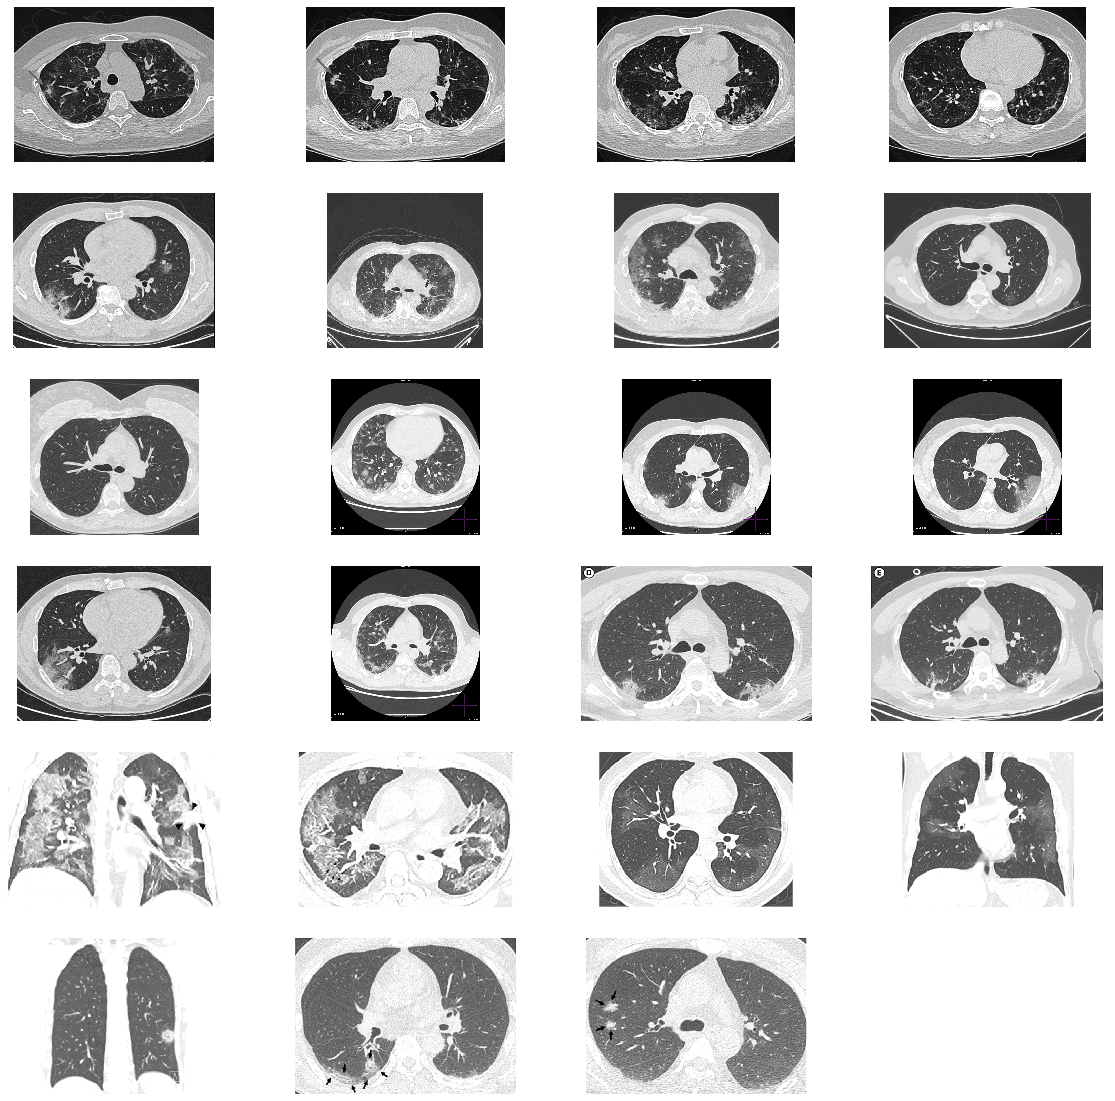

In [143]:
show_images(non_represented_images)

As we can see, all the missing images except two (which have indeed very low resolutions) are are cross sections. The dataset is entirely composed of front cuts of, at least, correct resolution.

[Go back to the top](#start)

## Variable Label  <a name="var_label"></a>
Type : string. Example : Normal

In [144]:
list(data.Label.unique())

['Normal', 'Pnemonia']

This variable shows the infection status.

Since this variable shows only those two modularities, we can cast it into a boolean variable named "infected".

In [145]:
data["infected"] = data.Label=="Pnemonia"

In [146]:
data.drop("Label", axis=1, inplace=True)
data

Unnamed: 0                       image Dataset_type  \
0              0           IM-0128-0001.jpeg        TRAIN   
1              1           IM-0127-0001.jpeg        TRAIN   
2              2           IM-0125-0001.jpeg        TRAIN   
3              3           IM-0122-0001.jpeg        TRAIN   
4              4           IM-0119-0001.jpeg        TRAIN   
...          ...                         ...          ...   
5905        5928  person1637_virus_2834.jpeg         TEST   
5906        5929  person1635_virus_2831.jpeg         TEST   
5907        5930  person1634_virus_2830.jpeg         TEST   
5908        5931  person1633_virus_2829.jpeg         TEST   
5909        5932  person1632_virus_2827.jpeg         TEST   

     Label_2_Virus_category Label_1_Virus_category  infected  
0                       NaN                    NaN     False  
1                       NaN                    NaN     False  
2                       NaN                    NaN     False  
3                       NaN                    NaN     False  
4                       NaN                    NaN     False  
...                     ...                    ...       ...  
5905                    NaN                  Virus      True  
5906                    NaN                  Virus      True  
5907                    NaN                  Virus      True  
5908                    NaN                  Virus      True  
5909                    NaN                  Virus      True  

[5910 rows x 6 columns]

In [147]:
infected_number = data.infected.sum()
print("%i of the %i patients are infected , which represent %.2f%% of the dataset."
     %(infected_number, len(data), infected_number*100/len(data)))

4334 of the 5910 patients are infected , which represent 73.33% of the dataset.


As we can see, this dataset is mostly composed of infected patients.

[Go back to the top](#start)

## Variable Dataset_type <a name="var_type"></a>

Type : string. Example : TRAIN


This variable shows a arbitrary split between test and train sets.
Since we are going to split it randomly (with random splits) we don't need it.

In [148]:
data.drop("Dataset_type", axis=1, inplace=True)
data

Unnamed: 0                       image Label_2_Virus_category  \
0              0           IM-0128-0001.jpeg                    NaN   
1              1           IM-0127-0001.jpeg                    NaN   
2              2           IM-0125-0001.jpeg                    NaN   
3              3           IM-0122-0001.jpeg                    NaN   
4              4           IM-0119-0001.jpeg                    NaN   
...          ...                         ...                    ...   
5905        5928  person1637_virus_2834.jpeg                    NaN   
5906        5929  person1635_virus_2831.jpeg                    NaN   
5907        5930  person1634_virus_2830.jpeg                    NaN   
5908        5931  person1633_virus_2829.jpeg                    NaN   
5909        5932  person1632_virus_2827.jpeg                    NaN   

     Label_1_Virus_category  infected  
0                       NaN     False  
1                       NaN     False  
2                       NaN     False  
3                       NaN     False  
4                       NaN     False  
...                     ...       ...  
5905                  Virus      True  
5906                  Virus      True  
5907                  Virus      True  
5908                  Virus      True  
5909                  Virus      True  

[5910 rows x 5 columns]

[Go back to the top](#start)

## Label_2_Virus_category and Label_1_Virus_category <a name="var_virus"></a>
Type : string. Example : Streptococcus

We have types and causes of pneumopathies of infected patients.

In [149]:
label1 = list(data.Label_1_Virus_category.dropna().unique())
label1

['Virus', 'bacteria', 'Stress-Smoking']

In [150]:
label2 = list(data.Label_2_Virus_category.dropna().unique())
label2

['Streptococcus', 'COVID-19', 'ARDS', 'SARS']

Let's make it more explicit by renaming "pathogen_type" and "pathogen". Also, we will replace the Nan by "Unknown".

In [151]:
data.rename(columns={"Label_2_Virus_category":"pathogen", "Label_1_Virus_category":"cause"}, inplace=True)
data["pathogen"] = data.pathogen.fillna("unknown")
data["cause"] = data.cause.fillna("unknown")

In [152]:
data

Unnamed: 0                       image pathogen    cause  infected
0              0           IM-0128-0001.jpeg  unknown  unknown     False
1              1           IM-0127-0001.jpeg  unknown  unknown     False
2              2           IM-0125-0001.jpeg  unknown  unknown     False
3              3           IM-0122-0001.jpeg  unknown  unknown     False
4              4           IM-0119-0001.jpeg  unknown  unknown     False
...          ...                         ...      ...      ...       ...
5905        5928  person1637_virus_2834.jpeg  unknown    Virus      True
5906        5929  person1635_virus_2831.jpeg  unknown    Virus      True
5907        5930  person1634_virus_2830.jpeg  unknown    Virus      True
5908        5931  person1633_virus_2829.jpeg  unknown    Virus      True
5909        5932  person1632_virus_2827.jpeg  unknown    Virus      True

[5910 rows x 5 columns]

In [153]:
pd.pivot_table(data[data.infected==False], "image", "pathogen", "cause", "count").fillna(0).astype(int)

cause     unknown
pathogen         
unknown      1576

Here we are certain that no cause are given when the patients are not infected.

In [154]:
pd.pivot_table(data[data.infected==True], "image", "pathogen", "cause", "count").fillna(0).astype(int)

cause          Stress-Smoking  Virus  bacteria
pathogen                                      
ARDS                        2      0         0
COVID-19                    0     58         0
SARS                        0      4         0
Streptococcus               0      0         5
unknown                     0   1493      2772

There seems to be no discrepencies about the given causes. Covid and SARS are indeed viruses, ARDS can be stress or smoke induced, and Streptococcus is a bacteria.

Since there are only a very few identified pathologies, and since they would have constituted target variables, the relevanty target variable of this dataset is the infection status. We therefore won't need the  cause and pathogen variable for the remaining of this analysis.

In [155]:
data.drop(["cause","pathogen"],axis=1, inplace=True)
data

Unnamed: 0                       image  infected
0              0           IM-0128-0001.jpeg     False
1              1           IM-0127-0001.jpeg     False
2              2           IM-0125-0001.jpeg     False
3              3           IM-0122-0001.jpeg     False
4              4           IM-0119-0001.jpeg     False
...          ...                         ...       ...
5905        5928  person1637_virus_2834.jpeg      True
5906        5929  person1635_virus_2831.jpeg      True
5907        5930  person1634_virus_2830.jpeg      True
5908        5931  person1633_virus_2829.jpeg      True
5909        5932  person1632_virus_2827.jpeg      True

[5910 rows x 3 columns]

[Go back to the top](#start)

# First classification glimpse <a name="glimpse"></a>

In [156]:
data[data.infected].sample()['image'].values[0]

'person598_virus_1154.jpeg'

Let's have a look to the images of some affected patients and healthy ones.

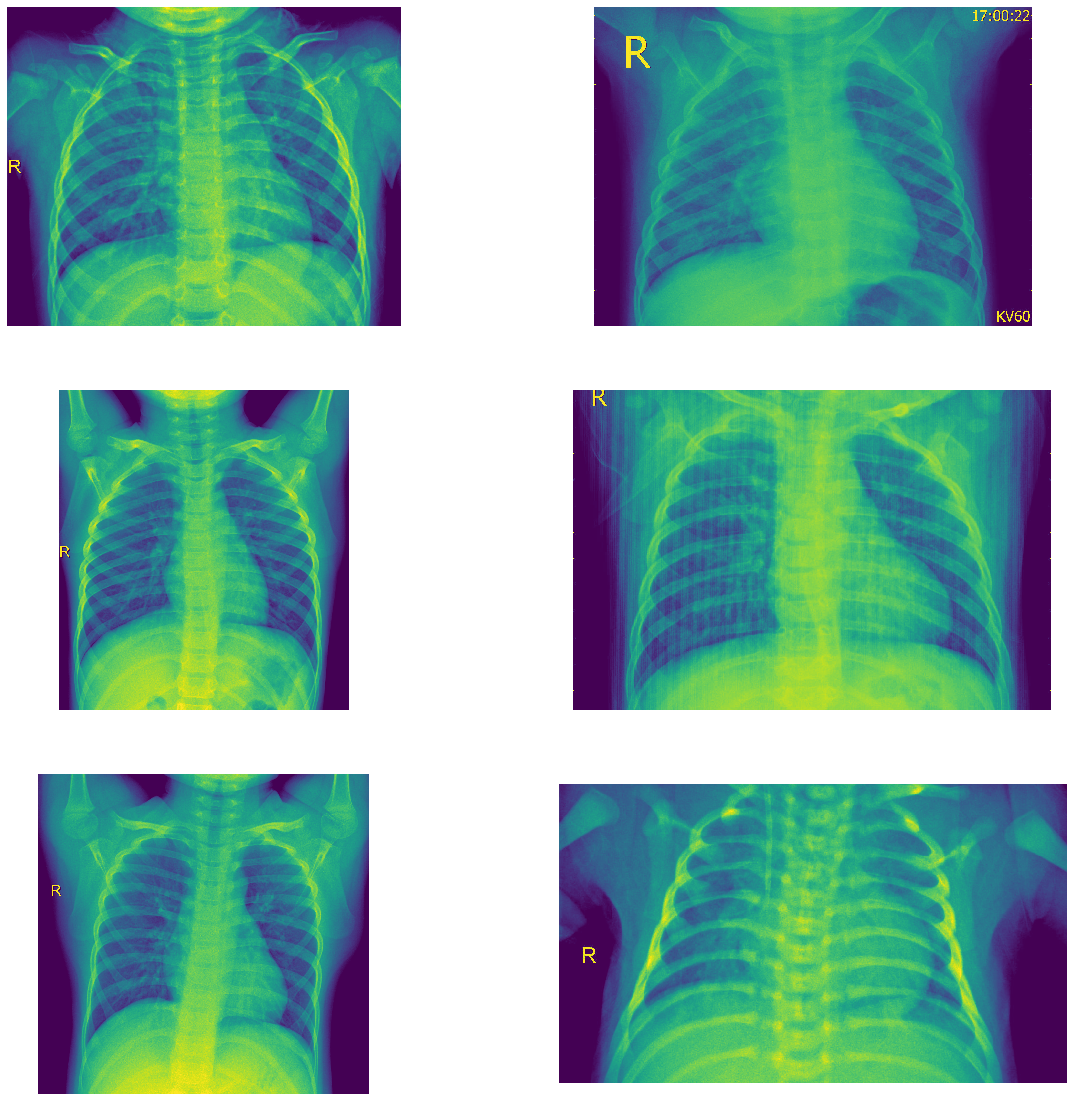

In [157]:
samples=[]
healthy_sample=data[~data.infected].sample(3)
infected_sample=data[data.infected].sample(3)
for i in range(3):
    samples.append(healthy_sample.image.values[i])
    samples.append(infected_sample.image.values[i])
show_images(samples)

Left images show healthy patients, right ones show infected patients, taken customly.

As it is not the goal of this study, we won't do extensive analyses on this data.

We will now directly train a CNN Model and see how it performs.

[Go back to the top](#start)

# Transforming the Data <a name="transform"></a>

The data will be computed in a very low level, using tensorflows. Because of this choice, we will have to split our data into three  batches : train, test and validation (70, 15 and 15% respectively).

In [158]:
data=data[["image","infected"]]
data["infected"] = data.infected.astype("str")

C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [159]:
data = shuffle(data)
data_len = len(data)
data_train = data[:int(data_len*700/1000)]
data_test = data[int(data_len*700/1000):int(data_len*850/1000)]
data_validation = data[int(data_len*850/1000):]

In [160]:
data

image infected
2965   person257_bacteria_1194.jpeg     True
377               IM-0530-0001.jpeg    False
3733   person438_bacteria_1892.jpeg     True
3741   person437_bacteria_1885.jpeg     True
2202  person1396_bacteria_3545.jpeg     True
...                             ...      ...
5792        person64_virus_122.jpeg     True
4322   person559_bacteria_2329.jpeg     True
2642  person1810_bacteria_4664.jpeg     True
5383      NORMAL2-IM-0328-0001.jpeg    False
2580  person1544_bacteria_4037.jpeg     True

[5910 rows x 2 columns]

In [161]:
print("Test set has %f%% infection rate, validation set has %f%% and test set has %f%% infection rate."%
      ((data_train.infected=="True").sum()*100/len(data_train),
       (data_validation.infected=="True").sum()*100/len(data_validation),
       (data_test.infected=="True").sum()*100/len(data_test)))

Test set has 73.120619% infection rate, validation set has 73.618940% and test set has 74.040632% infection rate.


The suffle is correct as true and false are present in all sets, at about the same proportions.

To avoid overfitting and improve the accuracy of the models, we are going to use tensorflow's ImageDataGenerator which will allow us to transform the image with rotation, shifting and flips.
To add noise, we need to create a custom function that will be called inside the ImageDataGenerator. But we won't do it in a first time.

In [162]:
def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

In [163]:
train_image_generator = ImageDataGenerator(rescale=1.0/255,
                                           rotation_range=90, 
                                           width_shift_range=0.15,
                                           height_shift_range=0.15, 
                                           horizontal_flip=True, 
                                           zoom_range=0.5)

In [164]:
test_image_generator = ImageDataGenerator(rescale=1.0/255)

In [165]:
train_generator = train_image_generator.flow_from_dataframe(
    dataframe=data_train,
    directory=image_dir,
    x_col='image',
    y_col='infected',
    target_size=(224, 224),
    batch_size=16,
    seed=seed,
    shuffle=True,
    class_mode='binary',
    color_mode="grayscale"
)

Found 4137 validated image filenames belonging to 2 classes.


In [166]:
validation_generator = train_image_generator.flow_from_dataframe(
    dataframe=data_validation,
    directory=image_dir,
    x_col='image',
    y_col='infected',
    target_size=(224, 224),
    batch_size=16,
    seed=seed,
    shuffle=True,
    class_mode='binary',
    color_mode="grayscale"
)

Found 887 validated image filenames belonging to 2 classes.


In [167]:
test_generator = test_image_generator.flow_from_dataframe(
    dataframe=data_test,
    directory=image_dir,
    x_col='image',
    y_col='infected',
    target_size=(224, 224),
    batch_size=16,
    seed=seed,
    shuffle=False,
    class_mode=None,
    color_mode="grayscale")

Found 886 validated image filenames.


[Go back to the top](#start)

# Desiging a model <a name="design"></a>

In [168]:
result_folder = "results/"

In [169]:
metrics = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')]
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        min_delta=1e-2,
        patience=3,
        verbose=1)]

## First benches <a name="bench"></a>

Let's define a function to help us plot our graphes.

In [170]:
def plot_history(dataframe, title,  metrics=["accuracy","loss"]):
    plt.figure(figsize=(10,5))
    for metric in metrics :
        plt.plot(dataframe[metric], label=metric)
    plt.axis([0,100,0,1])
    plt.grid(0.1)
    plt.title(title)
    plt.xlabel("epochs")
    plt.legend()
    plt.ylabel(" and ".join(metrics))

You'll find all the code as text, as well a the log of the output below it.

In [171]:
def read_log(file):
    with open(result_folder+file+".txt", "r") as f:
        print("\n".join(f.readlines()))

Firstly, we will try a model which has an architecture similar to some models used in similar studies and which have been rpoven to workd well, found on the Internet.

### Not noised <a name="bench_1"></a>

In [172]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2),padding="same"))
model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 53, 53, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 179776)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [173]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = metrics)

In [174]:
read_log("basic01")

Train for 259 steps, validate for 56 steps

Epoch 1/100

259/259 [==============================] - 39s 152ms/step - loss: 0.5609 - tp: 2786.0000 - fp: 868.0000 - tn: 241.0000 - fn: 242.0000 - accuracy: 0.7317 - precision: 0.7625 - recall: 0.9201 - auc: 0.7069 - val_loss: 0.4619 - val_tp: 598.0000 - val_fp: 142.0000 - val_tn: 94.0000 - val_fn: 53.0000 - val_accuracy: 0.7802 - val_precision: 0.8081 - val_recall: 0.9186 - val_auc: 0.8199

Epoch 2/100

259/259 [==============================] - 38s 148ms/step - loss: 0.4704 - tp: 2659.0000 - fp: 617.0000 - tn: 492.0000 - fn: 369.0000 - accuracy: 0.7617 - precision: 0.8117 - recall: 0.8781 - auc: 0.7987 - val_loss: 0.4319 - val_tp: 556.0000 - val_fp: 90.0000 - val_tn: 146.0000 - val_fn: 95.0000 - val_accuracy: 0.7914 - val_precision: 0.8607 - val_recall: 0.8541 - val_auc: 0.8382

Epoch 3/100

259/259 [==============================] - 38s 148ms/step - loss: 0.4387 - tp: 2683.0000 - fp: 537.0000 - tn: 572.0000 - fn: 345.0000 - accuracy: 0.7

In [175]:
df_basic = pd.read_csv(result_folder+"basic01.csv")

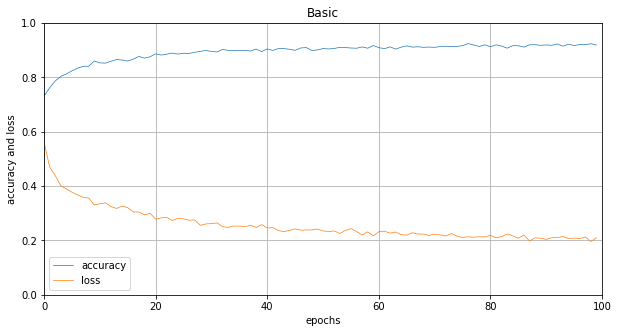

In [176]:
plot_history(df_basic, "Basic")

It achieved **91.67%** accuracy.

[Go back to the top](#start)

### Adding noise <a name="bench_2"></a>

In [177]:

noised_train_image_generator = ImageDataGenerator(rescale=1.0/255,
                                           rotation_range=90, 
                                           width_shift_range=0.15,
                                           height_shift_range=0.15, 
                                           horizontal_flip=True, 
                                           zoom_range=0.5,
                                          preprocessing_function=add_noise)

noised_train_generator = train_image_generator.flow_from_dataframe(
    dataframe=data_train,
    directory=image_dir,
    x_col='image',
    y_col='infected',
    target_size=(224, 224),
    batch_size=16,
    seed=seed,
    shuffle=True,
    class_mode='binary',
    color_mode="grayscale"
)
noised_validation_generator = train_image_generator.flow_from_dataframe(
    dataframe=data_validation,
    directory=image_dir,
    x_col='image',
    y_col='infected',
    target_size=(224, 224),
    batch_size=16,
    seed=seed,
    shuffle=True,
    class_mode='binary',
    color_mode="grayscale"
)
noised_test_generator = test_image_generator.flow_from_dataframe(
    dataframe=data_test,
    directory=image_dir,
    x_col='image',
    y_col='infected',
    target_size=(224, 224),
    batch_size=16,
    seed=seed,
    shuffle=False,
    class_mode=None,
    color_mode="grayscale")



Found 4137 validated image filenames belonging to 2 classes.
Found 887 validated image filenames belonging to 2 classes.
Found 886 validated image filenames.


In [178]:
pd.read_csv(result_folder+"basic01_noised.csv")

Unnamed: 0      loss      tp     fp     tn     fn  accuracy  precision  \
0            0  0.593959  2892.0  982.0  127.0  136.0  0.729756   0.746515   
1            1  0.453562  2711.0  636.0  473.0  317.0  0.769640   0.809979   
2            2  0.442068  2701.0  566.0  543.0  327.0  0.784143   0.826752   
3            3  0.430020  2704.0  525.0  584.0  324.0  0.794779   0.837411   
4            4  0.413935  2680.0  472.0  637.0  348.0  0.801789   0.850254   
..         ...       ...     ...    ...    ...    ...       ...        ...   
95          95  0.198220  2885.0  174.0  935.0  143.0  0.923374   0.943119   
96          96  0.192464  2868.0  148.0  961.0  160.0  0.925550   0.950928   
97          97  0.204492  2873.0  167.0  942.0  155.0  0.922166   0.945066   
98          98  0.194861  2881.0  162.0  947.0  147.0  0.925308   0.946763   
99          99  0.188466  2891.0  146.0  963.0  137.0  0.931593   0.951926   

      recall       auc  val_loss  val_tp  val_fp  val_tn  val_fn  \
0   0.955086  0.643494  0.465553   561.0    97.0   139.0    90.0   
1   0.895310  0.815651  0.423028   603.0   142.0    94.0    48.0   
2   0.892008  0.828889  0.405930   586.0    98.0   138.0    65.0   
3   0.892999  0.843764  0.394400   592.0    95.0   141.0    59.0   
4   0.885073  0.856125  0.418451   608.0   144.0    92.0    43.0   
..       ...       ...       ...     ...     ...     ...     ...   
95  0.952774  0.967919  0.159768   619.0    26.0   210.0    32.0   
96  0.947160  0.969871  0.191670   637.0    50.0   186.0    14.0   
97  0.948811  0.965982  0.189055   626.0    46.0   190.0    25.0   
98  0.951453  0.969598  0.211477   611.0    30.0   206.0    40.0   
99  0.954756  0.970151  0.175517   624.0    32.0   204.0    27.0   

    val_accuracy  val_precision  val_recall   val_auc  
0       0.789177       0.852584    0.861751  0.830704  
1       0.785795       0.809396    0.926267  0.851230  
2       0.816234       0.856725    0.900154  0.865712  
3       0.826381       0.861718    0.909370  0.868693  
4       0.789177       0.808511    0.933948  0.845993  
..           ...            ...         ...       ...  
95      0.934611       0.959690    0.950845  0.980636  
96      0.927847       0.927220    0.978495  0.974069  
97      0.919955       0.931548    0.961598  0.974638  
98      0.921082       0.953198    0.938556  0.968523  
99      0.933484       0.951219    0.958525  0.975575  

[100 rows x 19 columns]

In [179]:
df_noised = pd.read_csv(result_folder+"basic01_noised.csv")

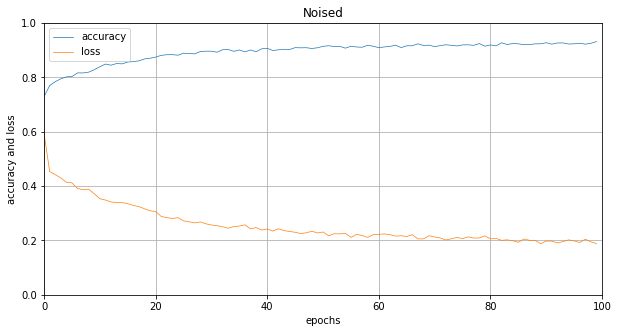

In [180]:
plot_history(df_noised, "Noised")

Adding noise, it achieved **93.4%** !

[Go back to the top](#start)

### Since we are working with an unbalanced dataset... <a name="unbalance"></a>

#### Why accuracy is not always a good metrics choice <a name="accuracy"></a>

We need a more favorable metrics.
The issue with accuracy is that, since we have 73% of positives, a model that says "positive" for all predictions will get an accuracy score of 73%. That is quite misleading.


#### Which metrics can we use, then ? <a name="metrics"></a>

For that reason, we will introduce and use another metrics, particularly useful with unbalaned datasets : the Matthews Correlation Coefficient ("MCC").

$Mathews\ Correlation\ Coefficient\ =\ \frac{True\ positives\ *\ True\ negatives\ +\ False\ positives\ *\ False\ negatives}{\sqrt{(True\ positives\ +\ False\ positives)(True\ positives\ +\ False\ negatives)(True\ negatives\ +\ False\ positive)(True\ negatives\ *\ False\ negatives)}}$

$MCC = \frac{TP\ *\ TN\ -\ FP\ *\ FN}{\sqrt{(TP\ +\ FP)(TP\ +\ FN)(TN\ +\ FP)(TN\ + FN)}}$

For the first model we trained, we got MCC of :

In [181]:
train_results = (2849, 921, 178, 189)
validation_results = (616,210,23,38)

In [182]:
def mcc(tp, tn, fp, fn):
    return (tp*tn - fp*fn) / ((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5
def mcc_df(df):
    return mcc(df.tp.values, df.tn.values, df.fp.values, df.fn.values)

In [183]:
print("Training set : %f\nValidation set : %f"% (mcc(*train_results),mcc(*validation_results)))

Training set : 0.773370
Validation set : 0.826823


We could have taken the more famous sensitivity (or recall) and specificity, but the MCC is the best of both worlds, in my humbe opinion.

[Go back to the top](#start)

### We can save accuracy though... <a name="save"></a>

Another solution to deal with unbalanced data is to introduce class weights. It is a factor that gives higher importances to a under-represented classes' positives and negatives. This way, the resulting accuracy truly represents the model ability to predict all classes.

In [184]:
def get_series_weights(series):
    weight = {}
    for value in series.unique():
        weight[value] = len(series)/(2*(series==value).sum())
    return weight

In [185]:
def get_weights(tp, tn, fp, fn):
    return {"positive":(tp+tn+fp+fn)/(2*(tp+fn)),
           "negative":(tp+tn+fp+fn)/(2*(tn+fp))}

In [186]:
class_weights = get_series_weights(data.infected)
print("Series weights : ", class_weights)

Series weights :  {'True': 0.6818181818181818, 'False': 1.875}


In [187]:
print("Train weights :%s\nValidation weights :%s"%(get_weights(*train_results), get_weights(*validation_results)) )

Train weights :{'positive': 0.6808755760368663, 'negative': 1.8821656050955413}
Validation weights :{'positive': 0.6781345565749235, 'negative': 1.9034334763948497}


In [188]:
def weighted_accuracy(tp, tn, fp, fn, positive_weight, negative_weight):
    tp*=positive_weight
    fn*=positive_weight
    tn*=negative_weight
    fp*=negative_weight
    return (tp+tn)/(tp+tn+fp+fn)

In [189]:
train_weights = get_weights(*train_results)
val_weights = get_weights(*validation_results)
print("Train balanced accuracy = ",weighted_accuracy(*train_results, train_weights["positive"], train_weights["negative"]))
print("Validation balanced accuracy = ", weighted_accuracy(*validation_results, val_weights["positive"], val_weights["negative"]))

Train balanced accuracy =  0.88791129766063
Validation balanced accuracy =  0.9215917890564502


Even though the weighted_accuracy score is better, it appropriately takes into account both classes representativity.

Here, we have derived the weighted score into one concise formula :

In [190]:
def weighted_accuracy(tp, tn, fp, fn):
    return (fn * tn + tp * fp + 2 * tp * tn) / (2 * (fn + tp) * (fp + tn))

def weighted_accuracy_df(df):
    return weighted_accuracy(df.tp.values, df.tn.values, df.fp.values, df.fn.values)

In [191]:
print("Train balanced accuracy = ",weighted_accuracy(*train_results))
print("Validation balanced accuracy = ", weighted_accuracy(*validation_results))

Train balanced accuracy =  0.8879112976606299
Validation balanced accuracy =  0.9215917890564502


$BALANCED\ ACC\ =\ \frac{TP\ *\ TN\ +\ TP\ *\ FP\ +\ 2\ *\ TP\ *\ TN}{2\ *\ (FN\ +\ TP)(FP\ +\ TN)}$

We just found the balanced accuracy, which doesn't seem to be often used.

We can compare it to the f1-score:

In [192]:
def f1_score(tp, tn, fp, fn):
    return 2*tp/(fn+fp+2*tp)

In [193]:
print("Train f1-score =",f1_score(*train_results))
print("Validation f1-score =", f1_score(*validation_results))

Train f1-score = 0.9394888705688376
Validation f1-score = 0.9528228924980665


In [194]:
def weighted_accuracy_df_series(df):
    tp=df.iloc[:,0]
    tn=df.iloc[:,2]
    fp=df.iloc[:,1]
    fn=df.iloc[:,3]
    return (fn * tn + tp * fp + 2 * tp * tn) / (2 * (fn + tp) * (fp + tn))
def mcc_df_series(df):
    tp=df.iloc[:,0]
    tn=df.iloc[:,2]
    fp=df.iloc[:,1]
    fn=df.iloc[:,3]
    return (tp*tn - fp*fn) / ((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5

We'll be showing MCC and balanced accuracy scores to estimate our models performance, but first let's have a last look at the regular metrics after setting the algorithm to take into account the weighted factors.

**Nota bene** This metric can also be calculated like so : 
$BALANCED\ ACC\ =\ \frac{RECALL\ +\ SPECIFICITY}{2}$

[Go back to the top](#start)

### Applying class_weights to the model <a name="weights"></a>

Before looking at the numbers, we should remember that loss values are not comparable between both model training, because weights change the range of the gradient.

The least represented class is 0. We need to transform our class_weights variable so it can be processed by our estimator.

In [195]:
generator_class_weight={}
for v in class_weights.values():
    if v>1:
        generator_class_weight[0]=v
    else:
        generator_class_weight[1]=v
generator_class_weight

{1: 0.6818181818181818, 0: 1.875}

#### With noise <a name="weights_1"></a>

In [196]:
read_log("basic01_weighted_noised")

Train for 259 steps, validate for 56 steps

Epoch 1/100

259/259 [==============================] - 39s 152ms/step - loss: 0.2395 - tp: 2733.0000 - fp: 85.0000 - tn: 1024.0000 - fn: 295.0000 - accuracy: 0.9081 - precision: 0.9698 - recall: 0.9026 - auc: 0.9644 - val_loss: 0.2326 - val_tp: 608.0000 - val_fp: 28.0000 - val_tn: 208.0000 - val_fn: 43.0000 - val_accuracy: 0.9200 - val_precision: 0.9560 - val_recall: 0.9339 - val_auc: 0.9708

Epoch 2/100

259/259 [==============================] - 37s 144ms/step - loss: 0.2312 - tp: 2752.0000 - fp: 93.0000 - tn: 1016.0000 - fn: 276.0000 - accuracy: 0.9108 - precision: 0.9673 - recall: 0.9089 - auc: 0.9671 - val_loss: 0.2210 - val_tp: 557.0000 - val_fp: 11.0000 - val_tn: 225.0000 - val_fn: 94.0000 - val_accuracy: 0.8816 - val_precision: 0.9806 - val_recall: 0.8556 - val_auc: 0.9762

Epoch 3/100

259/259 [==============================] - 38s 147ms/step - loss: 0.2404 - tp: 2727.0000 - fp: 96.0000 - tn: 1013.0000 - fn: 301.0000 - accuracy: 0.9

In [197]:
df_weighted_noised = pd.read_csv(result_folder+"basic01_weighted_noised.csv")

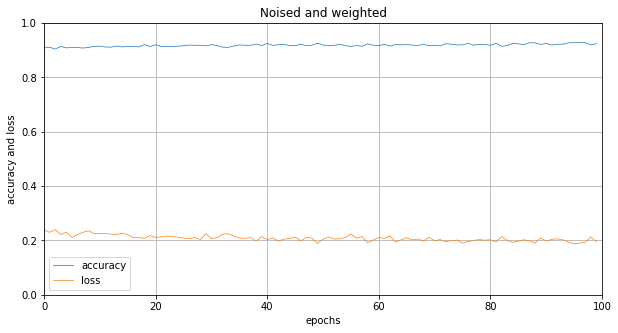

In [198]:
plot_history(df_weighted_noised, "Noised and weighted")

It achieved **93.1%** accuracy.

[Go back to the top](#start)

#### Without noise <a name="weights_2"></a>

In [199]:
read_log("basic01_weighted")

Train for 259 steps, validate for 56 steps

Epoch 1/100

259/259 [==============================] - 39s 149ms/step - loss: 0.2440 - tp: 2720.0000 - fp: 96.0000 - tn: 1013.0000 - fn: 308.0000 - accuracy: 0.9023 - precision: 0.9659 - recall: 0.8983 - auc: 0.9633 - val_loss: 0.2435 - val_tp: 599.0000 - val_fp: 24.0000 - val_tn: 212.0000 - val_fn: 52.0000 - val_accuracy: 0.9143 - val_precision: 0.9615 - val_recall: 0.9201 - val_auc: 0.9643

Epoch 2/100

259/259 [==============================] - 37s 144ms/step - loss: 0.2450 - tp: 2706.0000 - fp: 87.0000 - tn: 1022.0000 - fn: 322.0000 - accuracy: 0.9011 - precision: 0.9689 - recall: 0.8937 - auc: 0.9630 - val_loss: 0.2153 - val_tp: 581.0000 - val_fp: 12.0000 - val_tn: 224.0000 - val_fn: 70.0000 - val_accuracy: 0.9076 - val_precision: 0.9798 - val_recall: 0.8925 - val_auc: 0.9711

Epoch 3/100

259/259 [==============================] - 37s 144ms/step - loss: 0.2268 - tp: 2740.0000 - fp: 80.0000 - tn: 1029.0000 - fn: 288.0000 - accuracy: 0.9

In [200]:
df_weighted = pd.read_csv(result_folder+"basic01_weighted.csv")

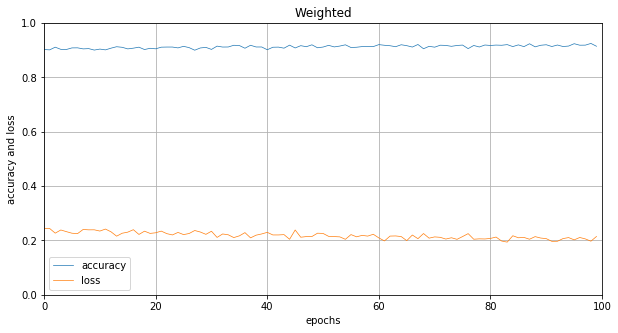

In [201]:
plot_history(df_weighted, "Weighted")

It achieved **92.33%** accuracy.

[Go back to the top](#start)

### Noise vs no noise, weighted vs not weighted <a name="versus"></a>

Even though the final accuracy scores are quite similar, we can notice three things already :
    - 1 Noised scores are higher that not noised.
    - 2 The loss intercept we got from the weighted mothod is lower. It reaches high accuracy scores much faster.
    - 3 Compution time are all similar.

Let's recap the basic metrics TP, TN, FP, FN and accuracy.

In [202]:
res = []
for df in [df_basic, df_noised, df_weighted, df_weighted_noised]:
    re = df.iloc[-1:]
    re = re.loc[-1:,["tp", "tn","fp","fn","accuracy"]]
    res.append(re)
result_df = pd.concat(res)
result_df.index = ["basic","noised","weighted","weighted_noised"]
result_df.sort_values("accuracy", ascending=False)

tp      tn     fp     fn  accuracy
noised           2891.0   963.0  146.0  137.0  0.931593
weighted_noised  2785.0  1037.0   72.0  243.0  0.923858
basic            2866.0   935.0  174.0  162.0  0.918782
weighted         2753.0  1030.0   79.0  275.0  0.914431

Now, let's add our favourites metrics : MCC and balanced accuracy

In [203]:
result_df["mcc"] = mcc_df(result_df.iloc[0:4])
result_df["balanced_accuracy"] = weighted_accuracy_df(result_df.iloc[0:4])
result_df.sort_values("balanced_accuracy", ascending=False)

tp      tn     fp     fn  accuracy       mcc  \
weighted_noised  2785.0  1037.0   72.0  243.0  0.923858  0.819146   
weighted         2753.0  1030.0   79.0  275.0  0.914431  0.798744   
noised           2891.0   963.0  146.0  137.0  0.931593  0.825240   
basic            2866.0   935.0  174.0  162.0  0.918782  0.792340   

                 balanced_accuracy  
weighted_noised           0.927413  
weighted                  0.918973  
noised                    0.911553  
basic                     0.894801

Even though the MCC doesn't agree, the balanced score clearly show a higher balanced accuracy of 92.7% for the weighted and noised method.

The weighted method makes half error on negatives, but double the error on positives. Overall, it gives a more  balanced score.

From now on, we will use the weighted method to evaluate our models.

[Go back to the top](#start)

## Choosing the number of subsampling blocks <a name="subs"></a>

We will try one to eight subsampling blocks and test which one gave the best results.

Thanks to the monochromatic coloring of our images, we are able to make calculation even with a single subsampling block.
As we have seen, 20 epochs are quite enough to get decent scores to compare.

In [204]:
read_log("subsampling")

Model: "sequential_32"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


conv2d_1917 (Conv2D)         (None, 224, 224, 24)      240       

_________________________________________________________________

max_pooling2d_1910 (MaxPooli (None, 112, 112, 24)      0         

_________________________________________________________________

flatten_24 (Flatten)         (None, 301056)            0         

_________________________________________________________________

dense_48 (Dense)             (None, 32)                9633824   

_________________________________________________________________

dense_49 (Dense)             (None, 1)                 33        


Total params: 9,634,097

Trainable params: 9,634,097

Non-trainable params: 0

_________________________________________________________________



Fitting with 1 subsampling block.




  ...

    to  

  ['...']


  ...

    to  

  ['.

In [205]:
matplotlib.rcParams['lines.linewidth'] = 0.7

C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


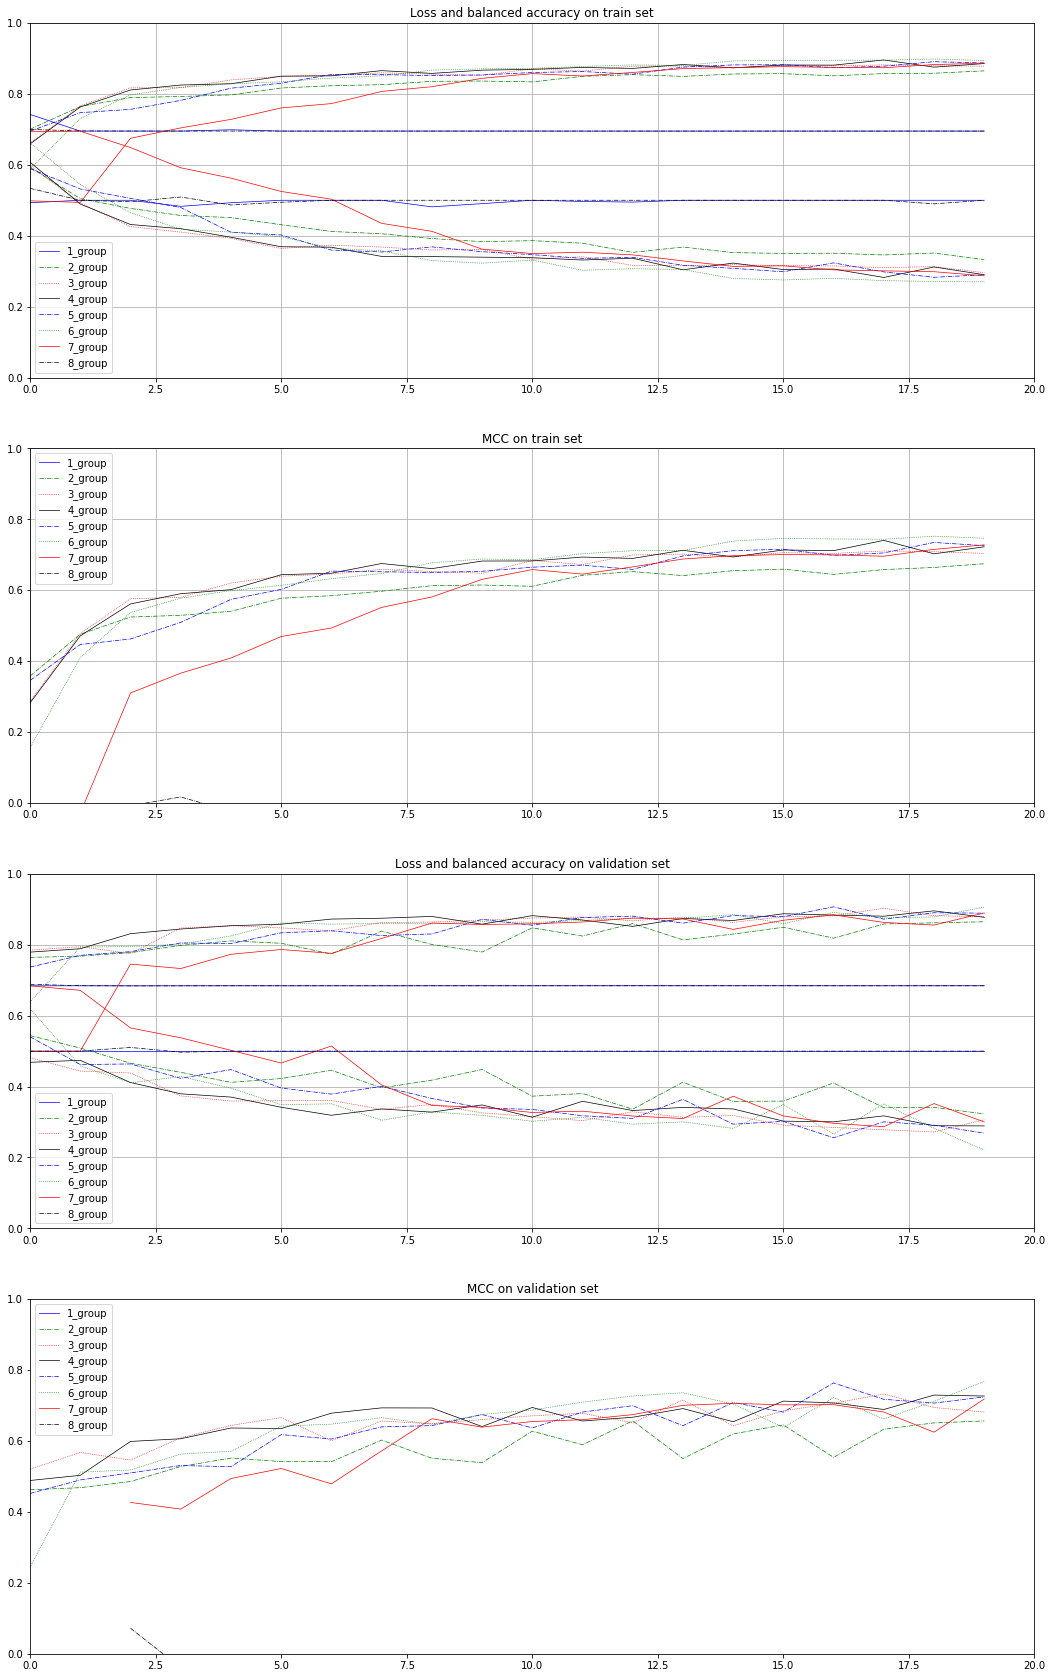

In [206]:
stls = ["-","-.",":"]
cols = ["b", "g", "r", "k"]
basic_metrics_train = ["tp", "tn", "fp", "fn"]
basic_metrics_val=["val_tp", "val_tn", "val_fp", "val_fn"]
fig, ax = plt.subplots(4,1, figsize=(18,30))
for i in range(8):
    df = pd.read_csv(result_folder+"sub_sampling_"+str(i+1)+".csv")
    label = str(i+1)+"_group"
    col = cols[i%(len(cols))]
    stl = stls[i%len(stls)]
    df["mcc"]=mcc_df(df.loc[:,basic_metrics_train])
    df["bal_acc"]=weighted_accuracy_df(df.loc[:,basic_metrics_train])
    df["val_mcc"]=mcc_df_series(df.iloc[:,[11,12,13,14]])
    df["val_bal_acc"]=weighted_accuracy_df_series(df.iloc[:,[11,12,13,14]])
    ax[0].plot(df.loss, color=col, linestyle=stl, label=label)
    ax[0].plot(df.bal_acc, color=col, linestyle=stl)
    ax[1].plot(df.mcc, color=col, linestyle=stl, label=label)
    ax[2].plot(df.val_loss, color=col, linestyle=stl, label=label)
    ax[2].plot(df.val_bal_acc, color=col, linestyle=stl)
    ax[3].plot(df.val_mcc, color=col, linestyle=stl, label=label)

titles = ["Loss and balanced accuracy on train set",
         "MCC on train set",
         "Loss and balanced accuracy on validation set",
         "MCC on validation set"]
for i in range(4):
    ax[i].axis([0,20,0,1])
    ax[i].legend()
    ax[i].set_title(titles[i])
    ax[i].grid()
plt.grid()
plt.show()

Here is a resume of what the results show :
    - 1 Computing times are the same, whatever the number of subsampling groups. This could be due by the fact than more subsampling ease the computation on the Dense layer, which is the most computation intensive. But it is more likely due to the parrallel complexity not being high enough, therefore the bottleneck is located in the CPU rather than the GPU.
    - 2 8 group shows 0 loss change, because the algorithm is too rigid, due to the fact that data coming to the Dense layer are very low dimension matrices, leading to divisions by zero.
    - 3 6 subsampling groups appear optimal. We are going to use for the remaining of the designing. 1 and 2 groups show significantly lower accuracy scores.

Let's design a function that will help keep the code more readable.

In [207]:
def get_model_subsampling(kernel_size=3, starting_filters=24, subsampling_blocks=6, consecutive_convs = 1, dropout=0, batch_normalization=False):
    model = Sequential()
    model.add(Conv2D(starting_filters,kernel_size=kernel_size,activation='relu',
            input_shape=(224,224,1), padding="same"))
    if batch_normalization:
        model.add(BatchNormalization())
        model.add(Conv2D(starting_filters,kernel_size=kernel_size,activation='relu', padding="same", strides=(2,2)))
    else:
        model.add(MaxPool2D(padding="same"))
    if dropout>0:
        model.add(Dropout(dropout))
    subs=1
    while(subs<subsampling_blocks):
        model.add(Conv2D(starting_filters*(subs+1),kernel_size=kernel_size,activation='relu', padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
            model.add(Conv2D(starting_filters*(subs+1),kernel_size=kernel_size,activation='relu', padding="same", strides=(2,2)))
        else:
            model.add(MaxPool2D(padding="same"))
        if dropout>0:
            model.add(Dropout(dropout))
        subs+=1
    return model

From now on, we will use a very similar methodology to decide which architecture parameters we will go with.

[Go back to the top](#start)

## Choosing the kernel size <a name="kernel"></a>

We will test kernel sizes from 2 to 8.

In [208]:
read_log("kernel_size")

Model: "sequential_43"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


conv2d_1961 (Conv2D)         (None, 224, 224, 24)      120       

_________________________________________________________________

max_pooling2d_1954 (MaxPooli (None, 112, 112, 24)      0         

_________________________________________________________________

conv2d_1962 (Conv2D)         (None, 112, 112, 24)      2328      

_________________________________________________________________

max_pooling2d_1955 (MaxPooli (None, 56, 56, 24)        0         

_________________________________________________________________

conv2d_1963 (Conv2D)         (None, 56, 56, 48)        4656      

_________________________________________________________________

max_pooling2d_1956 (MaxPooli (None, 28, 28, 48)        0         

_________________________________________________________________

conv2d_1964 (Conv2D)         (None, 2

C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


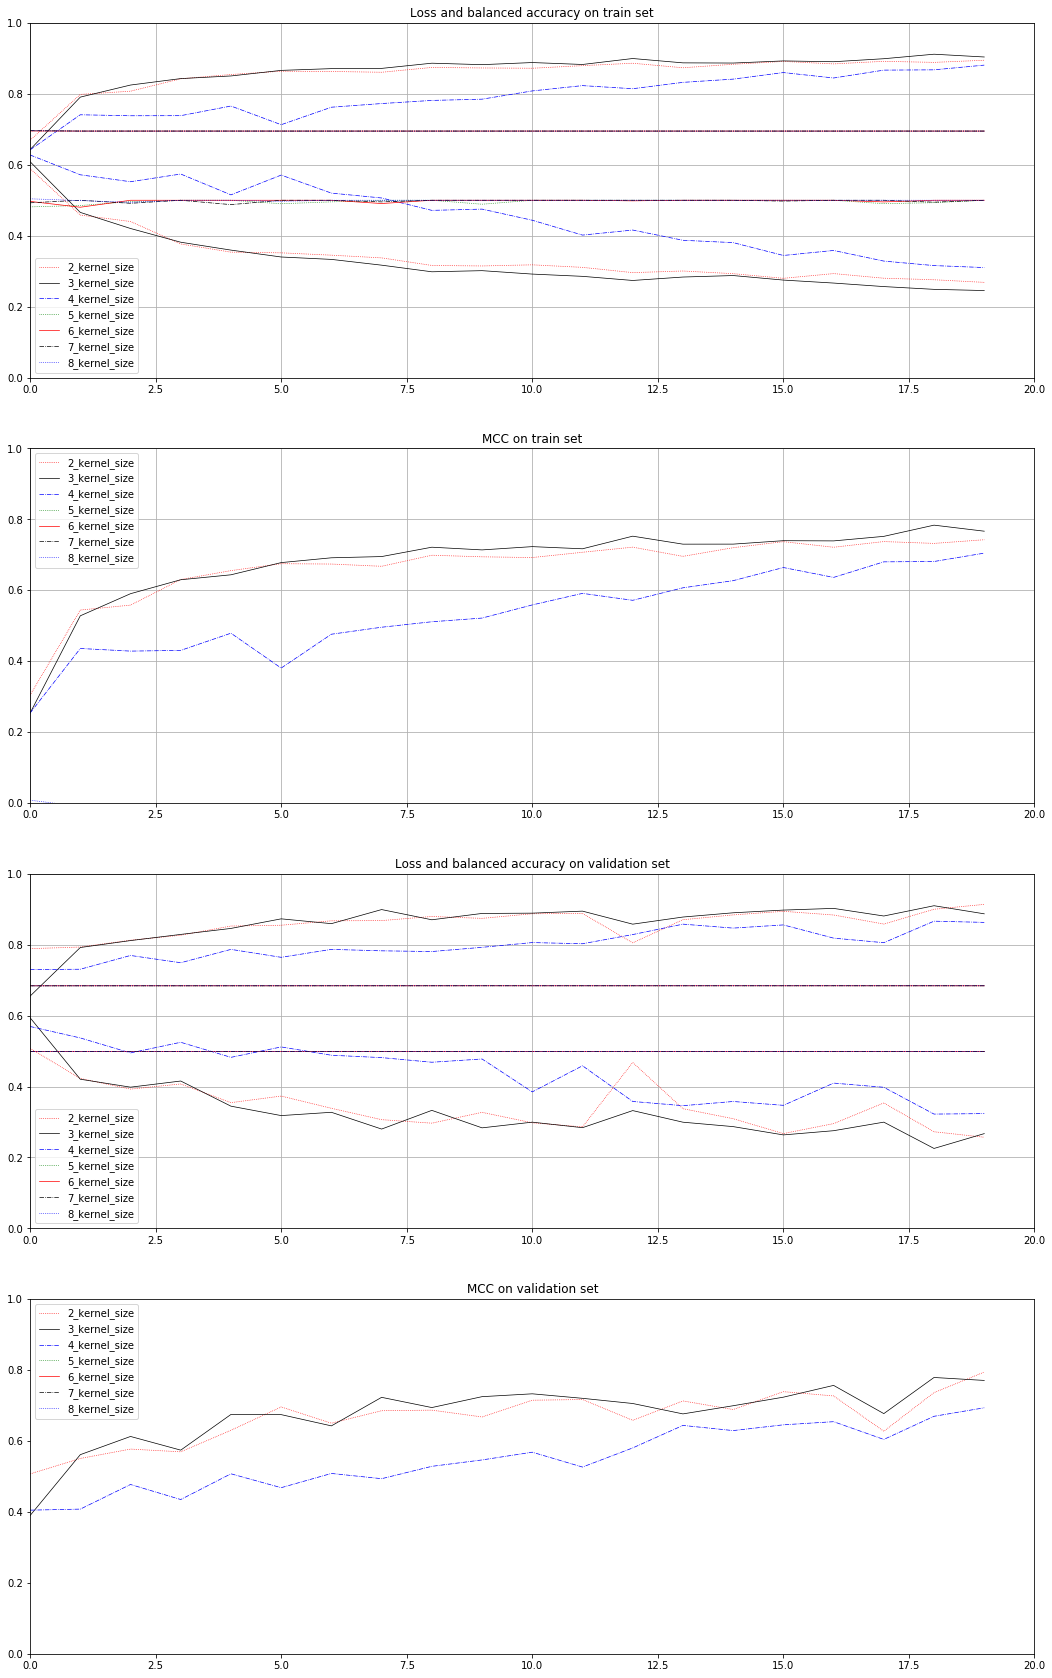

In [209]:
stls = ["-","-.",":"]
cols = ["b", "g", "r", "k"]
basic_metrics_train = ["tp", "tn", "fp", "fn"]
basic_metrics_val=["val_tp", "val_tn", "val_fp", "val_fn"]
fig, ax = plt.subplots(4,1, figsize=(18,30))
for i in range(2,9):
    df = pd.read_csv(result_folder+"kernel_size_"+str(i)+".csv")
    label = str(i)+"_kernel_size"
    col = cols[i%(len(cols))]
    stl = stls[i%len(stls)]
    df["mcc"]=mcc_df(df.loc[:,basic_metrics_train])
    df["bal_acc"]=weighted_accuracy_df(df.loc[:,basic_metrics_train])
    df["val_mcc"]=mcc_df_series(df.iloc[:,[11,12,13,14]])
    df["val_bal_acc"]=weighted_accuracy_df_series(df.iloc[:,[11,12,13,14]])
    ax[0].plot(df.loss, color=col, linestyle=stl, label=label)
    ax[0].plot(df.bal_acc, color=col, linestyle=stl)
    ax[1].plot(df.mcc, color=col, linestyle=stl, label=label)
    ax[2].plot(df.val_loss, color=col, linestyle=stl, label=label)
    ax[2].plot(df.val_bal_acc, color=col, linestyle=stl)
    ax[3].plot(df.val_mcc, color=col, linestyle=stl, label=label)

titles = ["Loss and balanced accuracy on train set",
         "MCC on train set",
         "Loss and balanced accuracy on validation set",
         "MCC on validation set"]
for i in range(4):
    ax[i].axis([0,20,0,1])
    ax[i].legend()
    ax[i].set_title(titles[i])
    ax[i].grid()
plt.grid()
plt.show()

Here again, the kernel size doesn't seem to have an impact on the computation time. The optimal kernel size is 3, but 2 is also a good choice. 4 still works ; higher will get us rigid models.

[Go back to the top](#start)

## Choosing filters size <a name="filters"></a>

In [210]:
read_log("filters_size")

Model: "sequential_52"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


conv2d_2010 (Conv2D)         (None, 224, 224, 2)       20        

_________________________________________________________________

max_pooling2d_2003 (MaxPooli (None, 112, 112, 2)       0         

_________________________________________________________________

conv2d_2011 (Conv2D)         (None, 112, 112, 2)       38        

_________________________________________________________________

max_pooling2d_2004 (MaxPooli (None, 56, 56, 2)         0         

_________________________________________________________________

conv2d_2012 (Conv2D)         (None, 56, 56, 4)         76        

_________________________________________________________________

max_pooling2d_2005 (MaxPooli (None, 28, 28, 4)         0         

_________________________________________________________________

conv2d_2013 (Conv2D)         (None, 2

C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


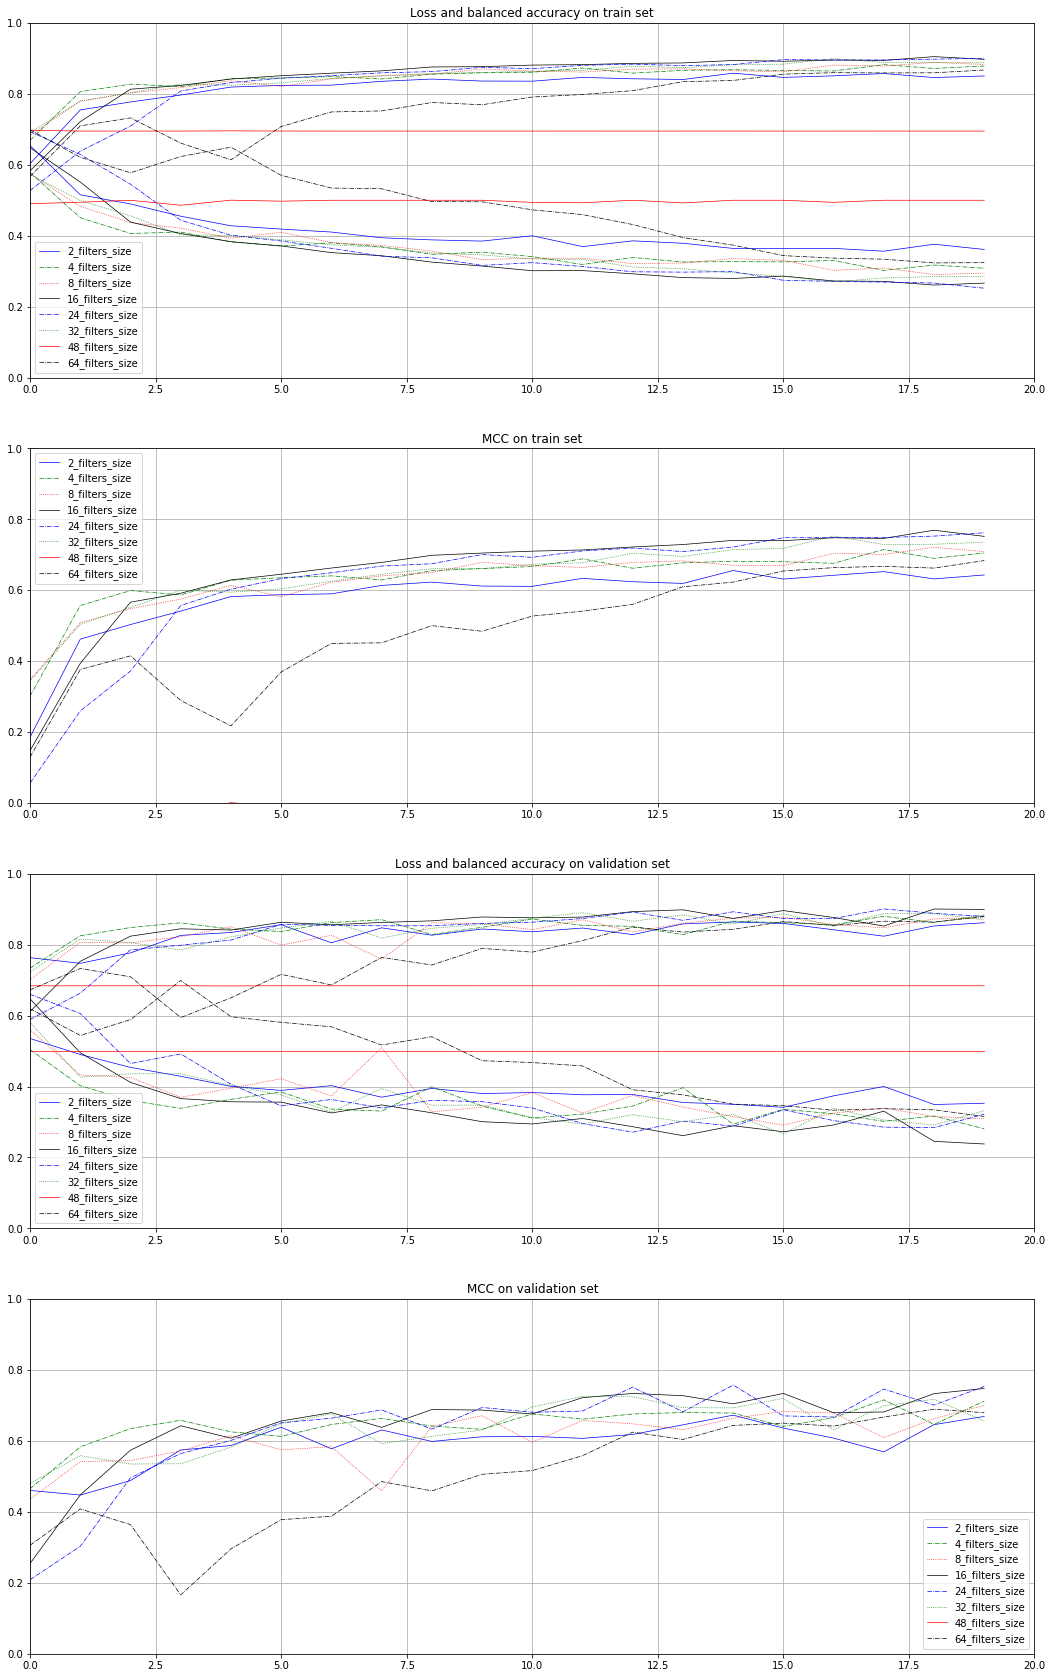

In [211]:
values = [2,4,8,16, 24, 32, 48, 64]
stls = ["-","-.",":"]
cols = ["b", "g", "r", "k"]
basic_metrics_train = ["tp", "tn", "fp", "fn"]
basic_metrics_val=["val_tp", "val_tn", "val_fp", "val_fn"]
fig, ax = plt.subplots(4,1, figsize=(18,30))

for i, val in enumerate(values):
    df = pd.read_csv(result_folder+"filters_size"+str(val)+".csv")
    label = str(val)+"_filters_size"
    col = cols[i%(len(cols))]
    stl = stls[i%len(stls)]
    df["mcc"]=mcc_df(df.loc[:,basic_metrics_train])
    df["bal_acc"]=weighted_accuracy_df(df.loc[:,basic_metrics_train])
    df["val_mcc"]=mcc_df_series(df.iloc[:,[11,12,13,14]])
    df["val_bal_acc"]=weighted_accuracy_df_series(df.iloc[:,[11,12,13,14]])
    ax[0].plot(df.loss, color=col, linestyle=stl, label=label)
    ax[0].plot(df.bal_acc, color=col, linestyle=stl)
    ax[1].plot(df.mcc, color=col, linestyle=stl, label=label)
    ax[2].plot(df.val_loss, color=col, linestyle=stl, label=label)
    ax[2].plot(df.val_bal_acc, color=col, linestyle=stl)
    ax[3].plot(df.val_mcc, color=col, linestyle=stl, label=label)

titles = ["Loss and balanced accuracy on train set",
         "MCC on train set",
         "Loss and balanced accuracy on validation set",
         "MCC on validation set"]
for i in range(4):
    ax[i].axis([0,20,0,1])
    ax[i].legend()
    ax[i].set_title(titles[i])
    ax[i].grid()
plt.show()

The best filter size to start with are between 16 and 32. We will go with 24 for the starting fitler size.



Let's also note that, here again, chossing different filter sizes didn't have an impact on the computation time needed.

[Go back to the top](#start)

## Choosing the Dense layer size <a name="dense"></a>

Since the range of possible values is quite wide, we will two passes to search an optimal value.
A first pass will focus on narrowing the range, the second will help us choose a moire precise number for this parameter.

### First pass <a name="pass_1"></a>

In [212]:
read_log("dense_size")

Model: "sequential_3"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


conv2d_15 (Conv2D)           (None, 224, 224, 24)      240       

_________________________________________________________________

max_pooling2d_14 (MaxPooling (None, 112, 112, 24)      0         

_________________________________________________________________

conv2d_16 (Conv2D)           (None, 112, 112, 24)      5208      

_________________________________________________________________

max_pooling2d_15 (MaxPooling (None, 56, 56, 24)        0         

_________________________________________________________________

conv2d_17 (Conv2D)           (None, 56, 56, 48)        10416     

_________________________________________________________________

max_pooling2d_16 (MaxPooling (None, 28, 28, 48)        0         

_________________________________________________________________

conv2d_18 (Conv2D)           (None, 28

C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


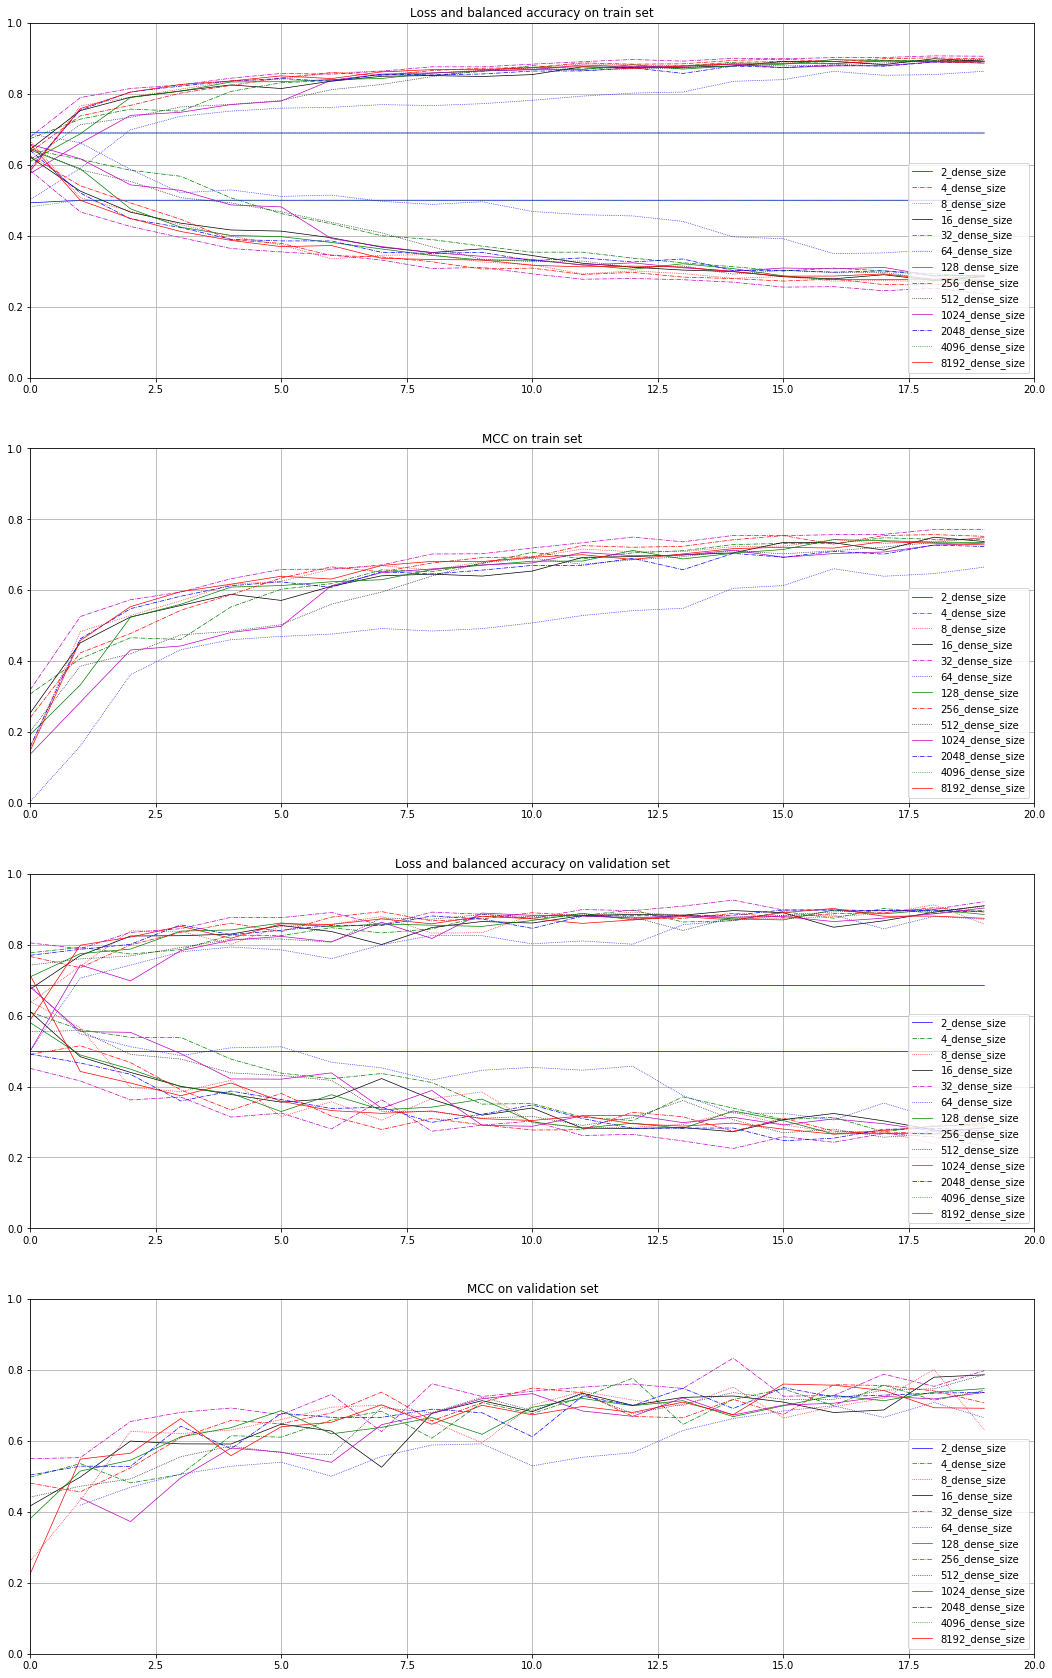

In [213]:
def plot_first_pass(zoom_box_acc=[0,20,0,1], zoom_box_mcc = [0,20,0,1]):
    powers = range(1, 14)
    stls = ["-","-.",":"]
    cols = ["b", "g", "r", "k", "m"]
    basic_metrics_train = ["tp", "tn", "fp", "fn"]
    basic_metrics_val=["val_tp", "val_tn", "val_fp", "val_fn"]
    fig, ax = plt.subplots(4,1, figsize=(18,30))

    for i, power in enumerate(powers):
        df = pd.read_csv(result_folder+"dense_size"+str(2**power)+".csv")
        label = str(2**power)+"_dense_size"
        col = cols[i%(len(cols))]
        stl = stls[i%len(stls)]
        df["mcc"]=mcc_df(df.loc[:,basic_metrics_train])
        df["bal_acc"]=weighted_accuracy_df(df.loc[:,basic_metrics_train])
        df["val_mcc"]=mcc_df_series(df.iloc[:,[11,12,13,14]])
        df["val_bal_acc"]=weighted_accuracy_df_series(df.iloc[:,[11,12,13,14]])
        ax[0].plot(df.loss, color=col, linestyle=stl, label=label)
        ax[0].plot(df.bal_acc, color=col, linestyle=stl)
        ax[1].plot(df.mcc, color=col, linestyle=stl, label=label)
        ax[2].plot(df.val_loss, color=col, linestyle=stl, label=label)
        ax[2].plot(df.val_bal_acc, color=col, linestyle=stl)
        ax[3].plot(df.val_mcc, color=col, linestyle=stl, label=label)

    titles = ["Loss and balanced accuracy on train set",
             "MCC on train set",
             "Loss and balanced accuracy on validation set",
             "MCC on validation set"]
    for i in range(4):
        ax[i].axis(zoom_box_acc if i%2 ==0 else zoom_box_mcc)
        ax[i].legend()
        ax[i].set_title(titles[i])
        ax[i].grid()
    plt.show()
plot_first_pass()

Let's zoom in.

C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


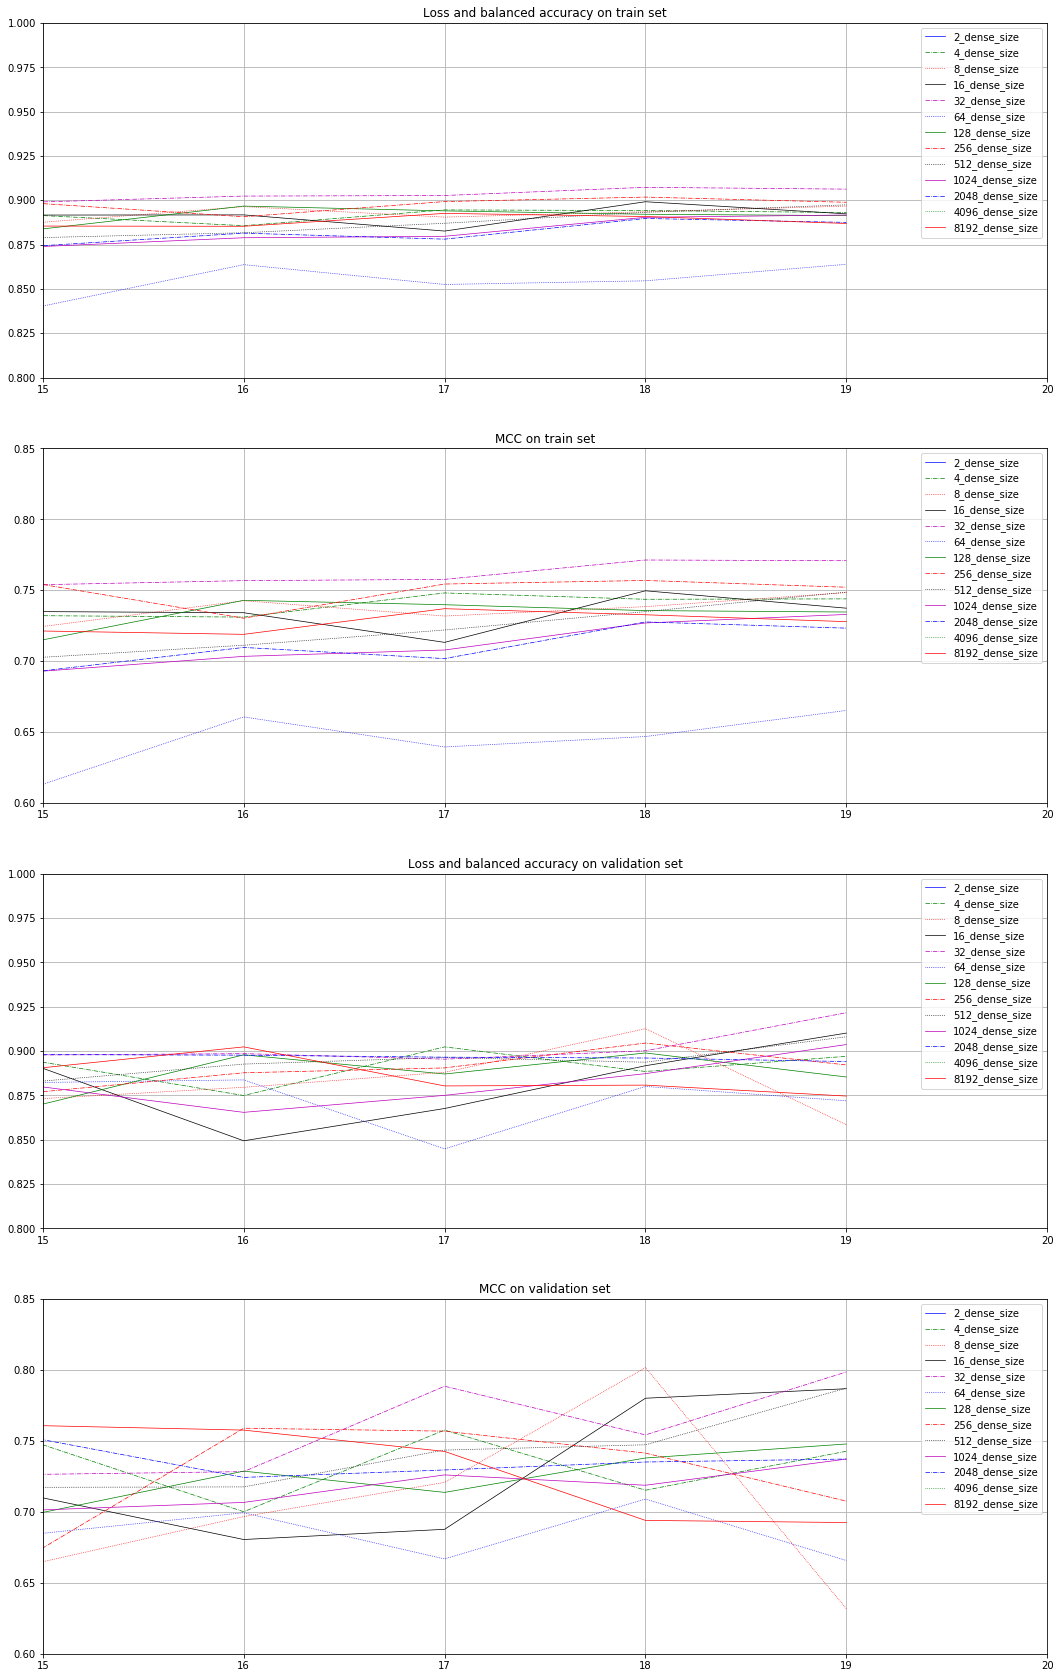

In [214]:
plot_first_pass((15,20,0.8,1), (15,20,0.6,0.85))

32 is the best choice of Dense layer size here. Let's try other values between 16 and 64.

[Go back to the top](#start)

#### Second pass <a name="pass_2"></a>

In [215]:
read_log("dense_size_2ndpass")

Model: "sequential_16"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


conv2d_93 (Conv2D)           (None, 224, 224, 24)      240       

_________________________________________________________________

max_pooling2d_92 (MaxPooling (None, 112, 112, 24)      0         

_________________________________________________________________

conv2d_94 (Conv2D)           (None, 112, 112, 24)      5208      

_________________________________________________________________

max_pooling2d_93 (MaxPooling (None, 56, 56, 24)        0         

_________________________________________________________________

conv2d_95 (Conv2D)           (None, 56, 56, 48)        10416     

_________________________________________________________________

max_pooling2d_94 (MaxPooling (None, 28, 28, 48)        0         

_________________________________________________________________

conv2d_96 (Conv2D)           (None, 2

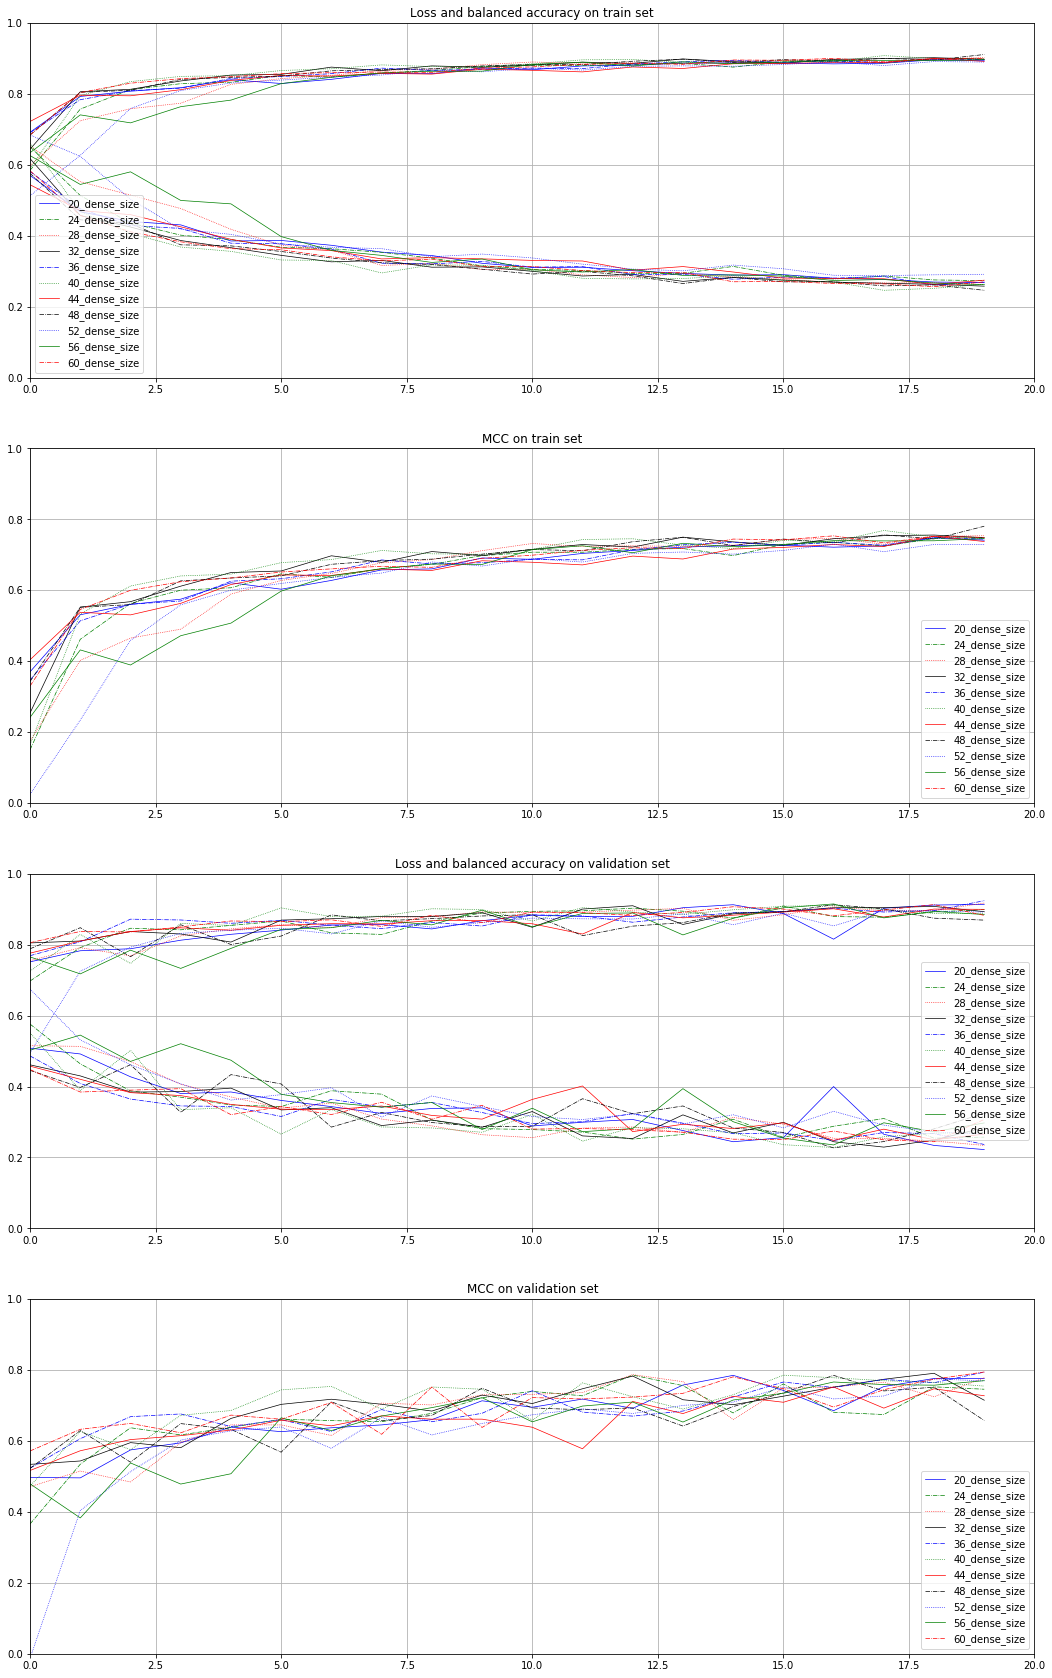

In [216]:
def plot_second_pass(zoom_box_acc=[0,20,0,1], zoom_box_mcc = [0,20,0,1]):
    values = range(20, 64, 4)
    stls = ["-","-.",":"]
    cols = ["b", "g", "r", "k"]
    basic_metrics_train = ["tp", "tn", "fp", "fn"]
    basic_metrics_val=["val_tp", "val_tn", "val_fp", "val_fn"]
    fig, ax = plt.subplots(4,1, figsize=(18,30))

    for i, value in enumerate(values):
        df = pd.read_csv(result_folder+"dense_size_2ndpass_"+str(value)+".csv")
        label = str(value)+"_dense_size"
        col = cols[i%(len(cols))]
        stl = stls[i%len(stls)]
        df["mcc"]=mcc_df(df.loc[:,basic_metrics_train])
        df["bal_acc"]=weighted_accuracy_df(df.loc[:,basic_metrics_train])
        df["val_mcc"]=mcc_df_series(df.iloc[:,[11,12,13,14]])
        df["val_bal_acc"]=weighted_accuracy_df_series(df.iloc[:,[11,12,13,14]])
        ax[0].plot(df.loss, color=col, linestyle=stl, label=label)
        ax[0].plot(df.bal_acc, color=col, linestyle=stl)
        ax[1].plot(df.mcc, color=col, linestyle=stl, label=label)
        ax[2].plot(df.val_loss, color=col, linestyle=stl, label=label)
        ax[2].plot(df.val_bal_acc, color=col, linestyle=stl)
        ax[3].plot(df.val_mcc, color=col, linestyle=stl, label=label)

    titles = ["Loss and balanced accuracy on train set",
             "MCC on train set",
             "Loss and balanced accuracy on validation set",
             "MCC on validation set"]
    for i in range(4):
        ax[i].axis(zoom_box_acc if i%2==0 else zoom_box_mcc)
        ax[i].legend()
        ax[i].set_title(titles[i])
        ax[i].grid()
    plt.show()
    
plot_second_pass()

Zooming in...

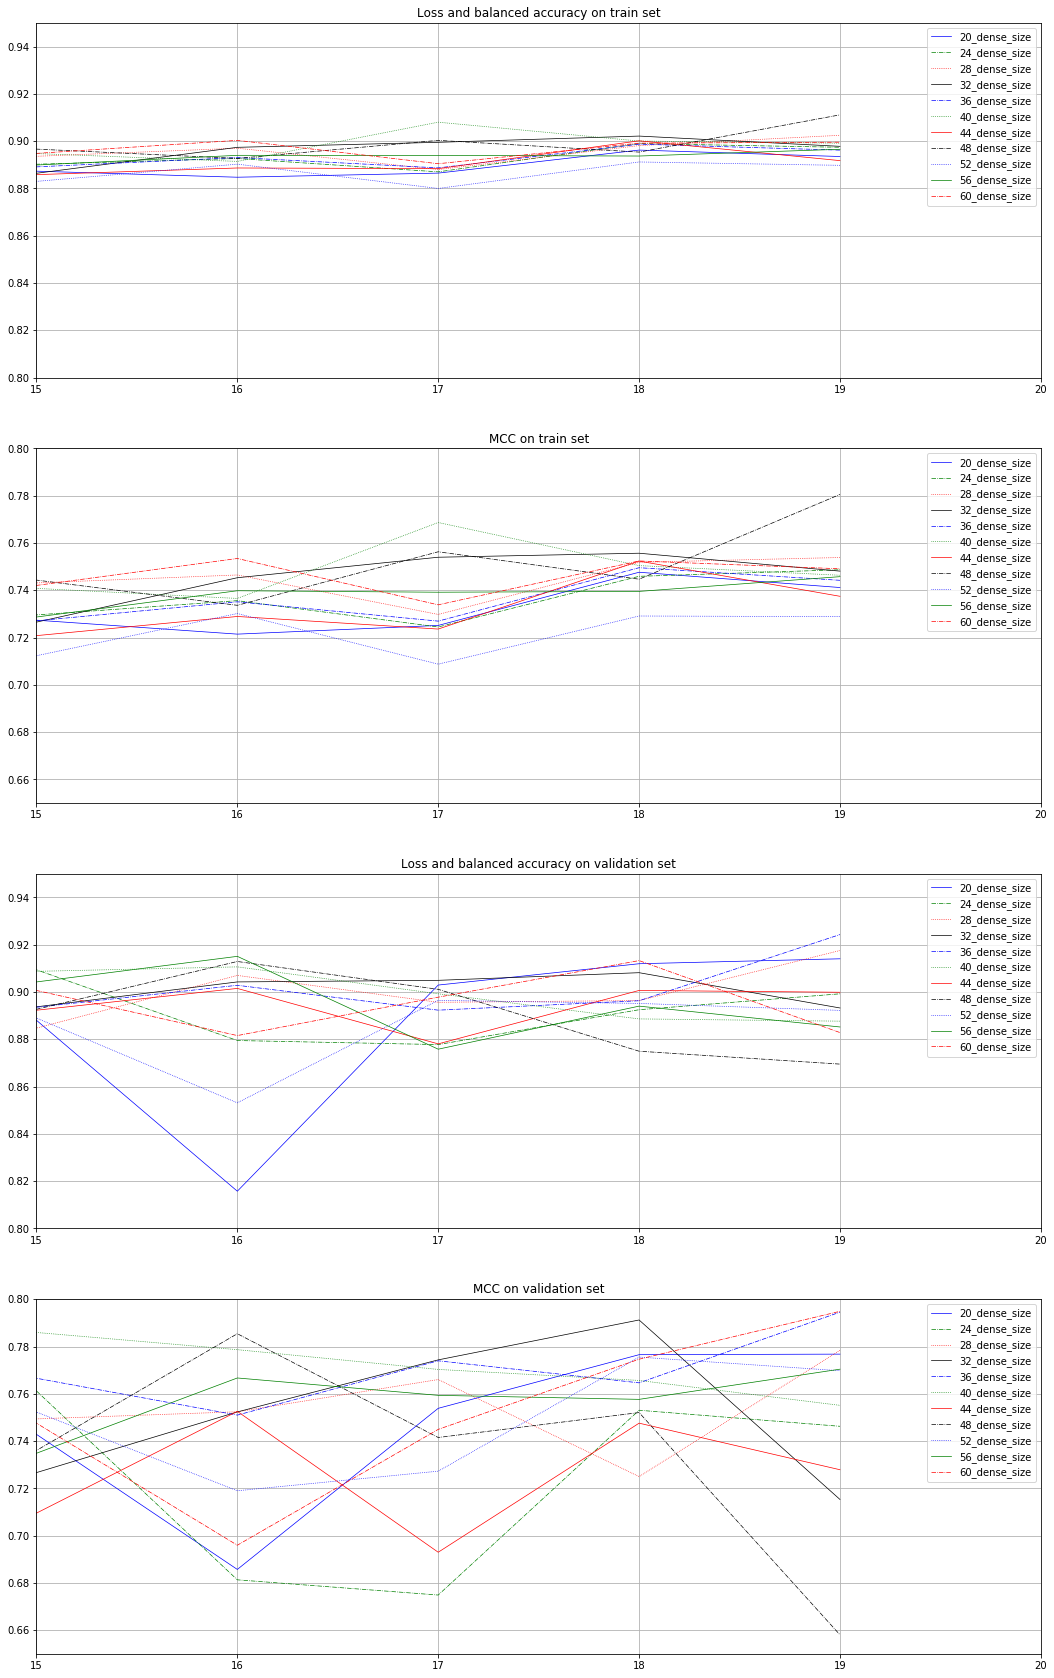

In [217]:
plot_second_pass((15,20,0.8,0.95),(15,20,0.65,0.8))

Results here are very similar. We will choose 40 as it seems to give consistent results.

[Go back to the top](#start)

## Adding Batch normalization instead of MaxPooling <a name="batch"></a>

We will try to replace Max Pooling by batch Normalization. As the BatchNormalization will replace the Max Pooling, we will include, for each convolution layer, another convolution layer with a sliding window of 2.
As we are dealing with more advanced features that better avoid overfitting, we will set test of 40 epochs instead of 20.


In [218]:
read_log("batch_norm")

Model: "sequential_1"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


conv2d_3 (Conv2D)            (None, 224, 224, 40)      400       

_________________________________________________________________

batch_normalization (BatchNo (None, 224, 224, 40)      160       

_________________________________________________________________

conv2d_4 (Conv2D)            (None, 112, 112, 40)      14440     

_________________________________________________________________

conv2d_5 (Conv2D)            (None, 112, 112, 40)      14440     

_________________________________________________________________

batch_normalization_1 (Batch (None, 112, 112, 40)      160       

_________________________________________________________________

conv2d_6 (Conv2D)            (None, 56, 56, 40)        14440     

_________________________________________________________________

conv2d_7 (Conv2D)            (None, 56

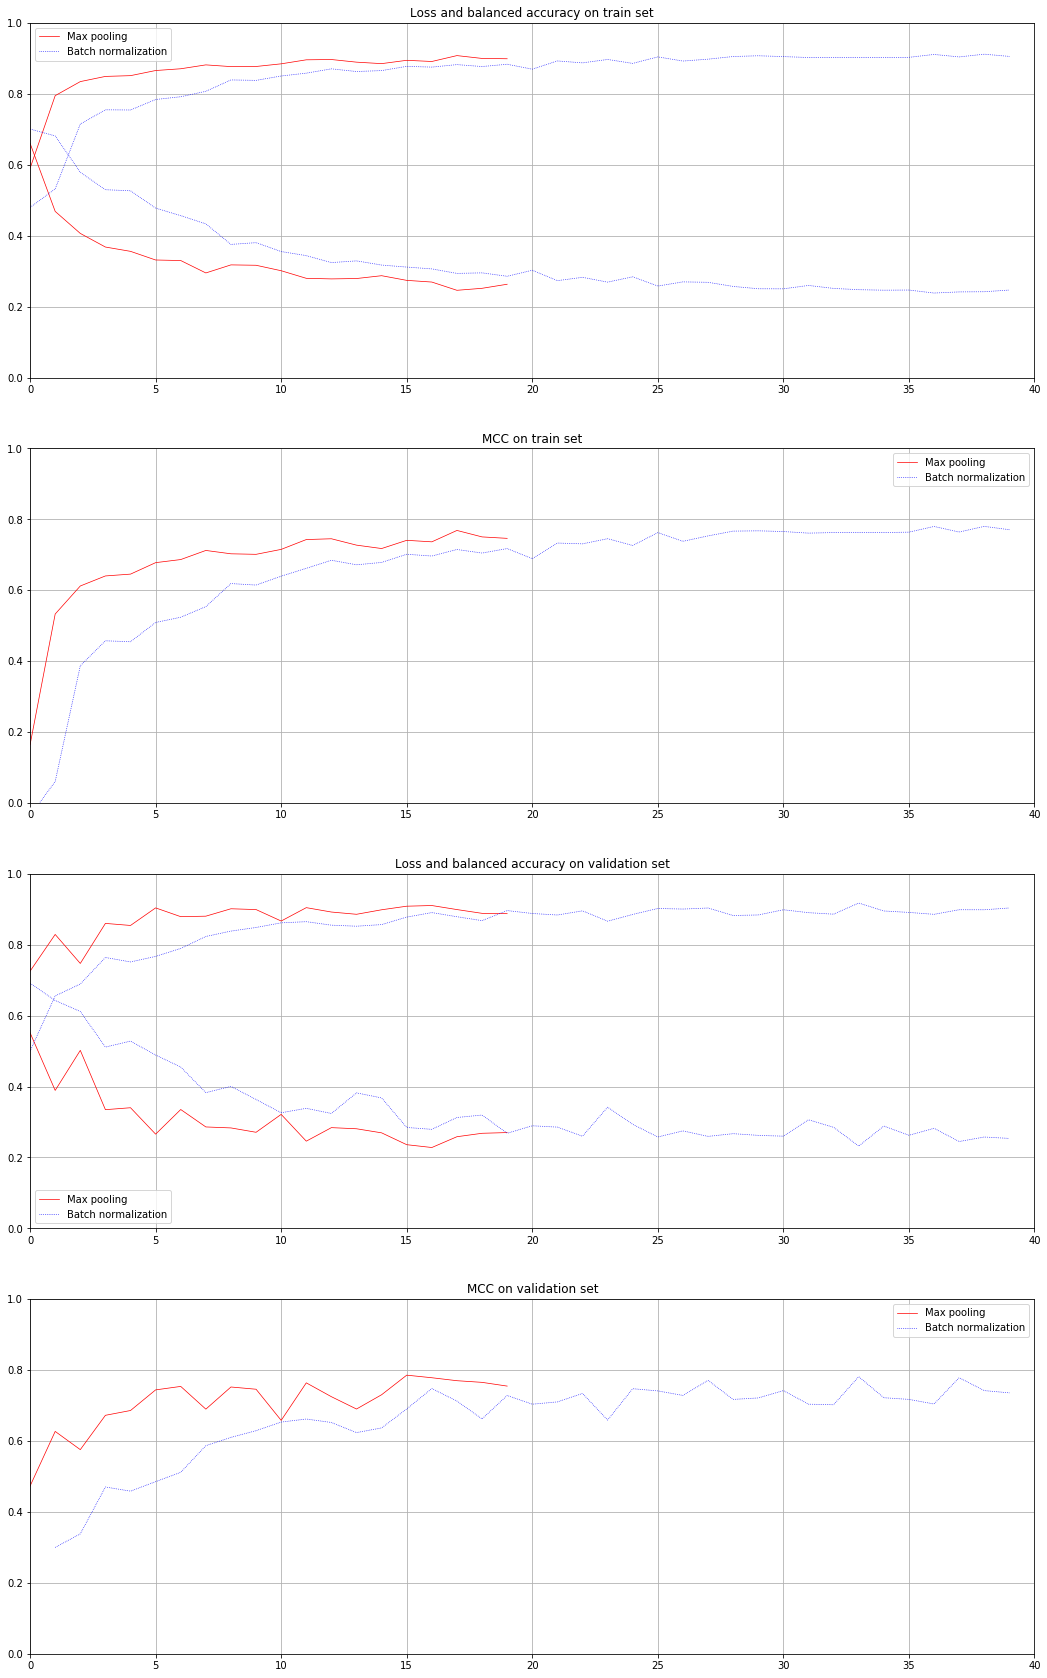

In [219]:
basic_metrics_train = ["tp", "tn", "fp", "fn"]
basic_metrics_val=["val_tp", "val_tn", "val_fp", "val_fn"]
fig, ax = plt.subplots(4,1, figsize=(18,30))

df = pd.read_csv(result_folder+"dense_size_2ndpass_40.csv")
label = "Max pooling"
col = "r"
stl = "-"
df["mcc"]=mcc_df(df.loc[:,basic_metrics_train])
df["bal_acc"]=weighted_accuracy_df(df.loc[:,basic_metrics_train])
df["val_mcc"]=mcc_df_series(df.iloc[:,[11,12,13,14]])
df["val_bal_acc"]=weighted_accuracy_df_series(df.iloc[:,[11,12,13,14]])
ax[0].plot(df.loss, color=col, linestyle=stl, label=label)
ax[0].plot(df.bal_acc, color=col, linestyle=stl)
ax[1].plot(df.mcc, color=col, linestyle=stl, label=label)
ax[2].plot(df.val_loss, color=col, linestyle=stl, label=label)
ax[2].plot(df.val_bal_acc, color=col, linestyle=stl)
ax[3].plot(df.val_mcc, color=col, linestyle=stl, label=label)

df = pd.read_csv(result_folder+"batch_norm.csv")
label = "Batch normalization"
col = "b"
stl = ":"
df["mcc"]=mcc_df(df.loc[:,basic_metrics_train])
df["bal_acc"]=weighted_accuracy_df(df.loc[:,basic_metrics_train])
df["val_mcc"]=mcc_df_series(df.iloc[:,[11,12,13,14]])
df["val_bal_acc"]=weighted_accuracy_df_series(df.iloc[:,[11,12,13,14]])
ax[0].plot(df.loss, color=col, linestyle=stl, label=label)
ax[0].plot(df.bal_acc, color=col, linestyle=stl)
ax[1].plot(df.mcc, color=col, linestyle=stl, label=label)
ax[2].plot(df.val_loss, color=col, linestyle=stl, label=label)
ax[2].plot(df.val_bal_acc, color=col, linestyle=stl)
ax[3].plot(df.val_mcc, color=col, linestyle=stl, label=label)
    
titles = ["Loss and balanced accuracy on train set",
         "MCC on train set",
         "Loss and balanced accuracy on validation set",
         "MCC on validation set"]
for i in range(4):
    ax[i].axis([0,40,0,1])
    ax[i].legend()
    ax[i].set_title(titles[i])
    ax[i].grid()
plt.show()

Batch normalization gives very inconsistent resuls in the validation set, although it shows lower scores on the early epochs .
Since we are at the last stage of this designing, we will try the next test with and without batch normalization as well.

[Go back to the top](#start)

## Adding dropout <a name="dropout"></a>

Let's try testing dropout from 10 to 80%.

### With batch normalization <a name="dropout_1"></a>

In [220]:
read_log("dropout")

Model: "sequential_4"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


conv2d_33 (Conv2D)           (None, 224, 224, 40)      400       

_________________________________________________________________

batch_normalization_12 (Batc (None, 224, 224, 40)      160       

_________________________________________________________________

conv2d_34 (Conv2D)           (None, 112, 112, 40)      14440     

_________________________________________________________________

dropout (Dropout)            (None, 112, 112, 40)      0         

_________________________________________________________________

conv2d_35 (Conv2D)           (None, 112, 112, 40)      14440     

_________________________________________________________________

batch_normalization_13 (Batc (None, 112, 112, 40)      160       

_________________________________________________________________

conv2d_36 (Conv2D)           (None, 56

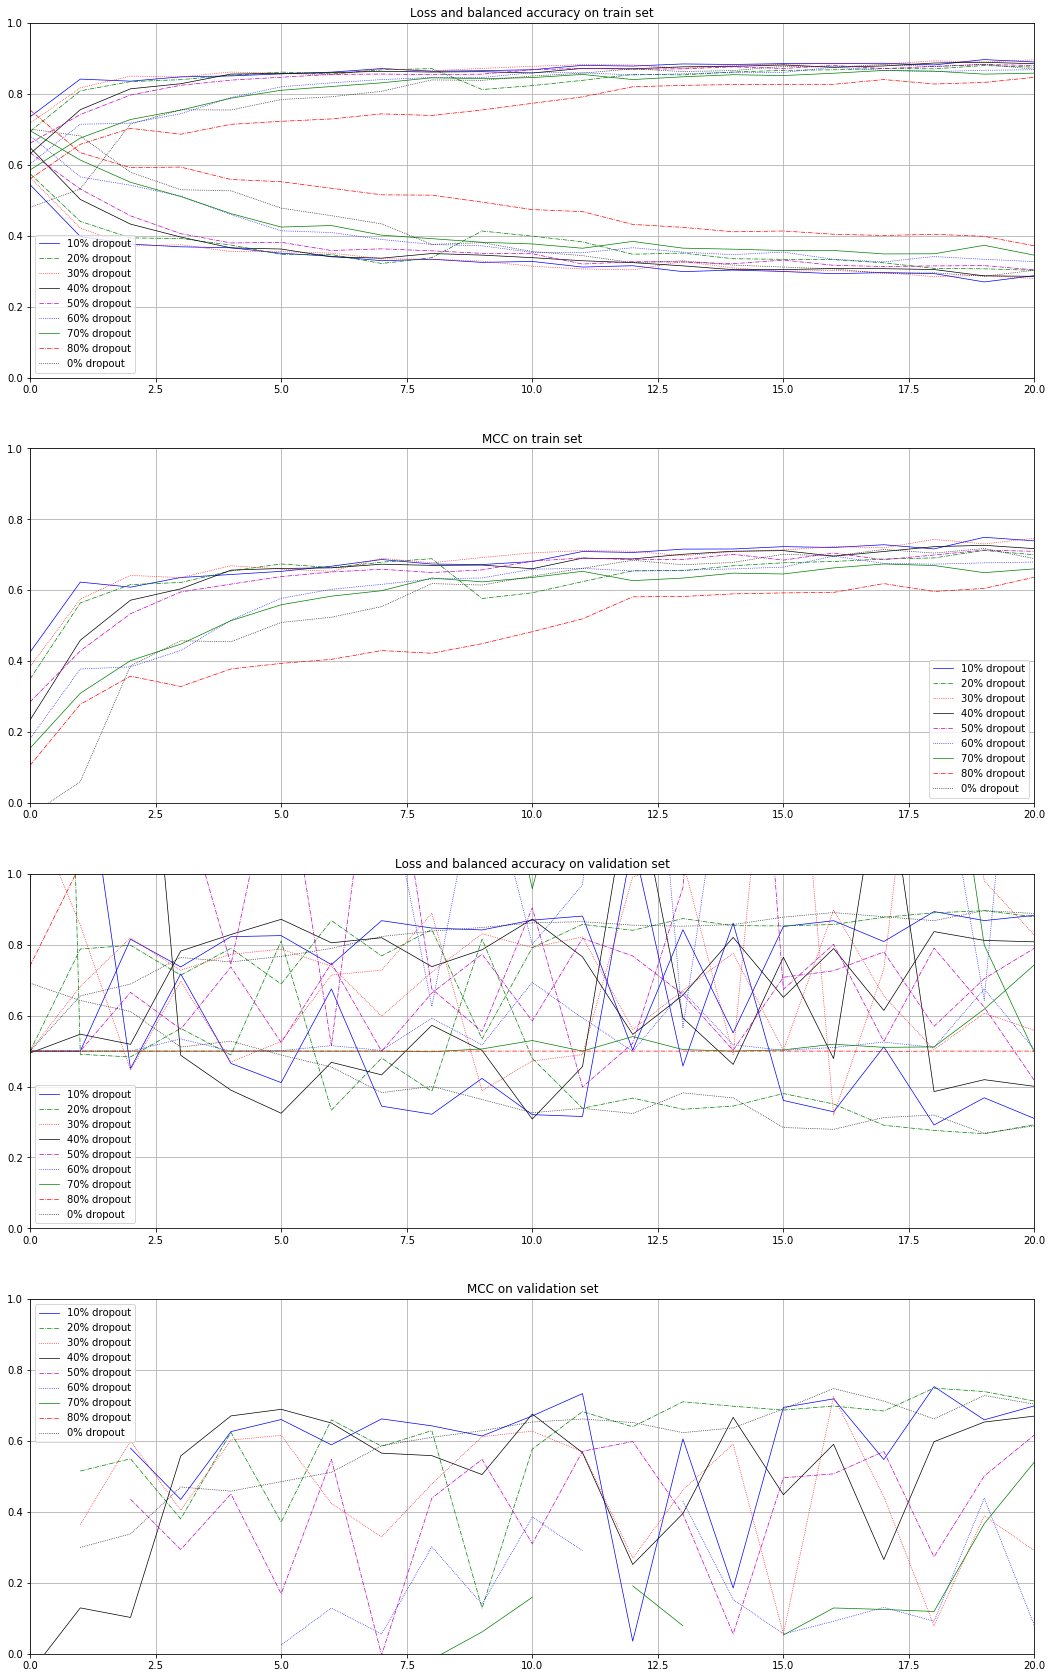

In [221]:
dropouts = range(10,90, 10)
stls = ["-","-.",":"]
cols = ["b", "g", "r", "k", "m"]
basic_metrics_train = ["tp", "tn", "fp", "fn"]
basic_metrics_val=["val_tp", "val_tn", "val_fp", "val_fn"]
fig, ax = plt.subplots(4,1, figsize=(18,30))

for i, dropout in enumerate(dropouts):
    df = pd.read_csv(result_folder+"dropout_"+str(dropout)+".csv")
    label = str(dropout)+"% dropout"
    col = cols[i%(len(cols))]
    stl = stls[i%len(stls)]
    df["mcc"]=mcc_df(df.loc[:,basic_metrics_train])
    df["bal_acc"]=weighted_accuracy_df(df.loc[:,basic_metrics_train])
    df["val_mcc"]=mcc_df_series(df.iloc[:,[11,12,13,14]])
    df["val_bal_acc"]=weighted_accuracy_df_series(df.iloc[:,[11,12,13,14]])
    ax[0].plot(df.loss, color=col, linestyle=stl, label=label)
    ax[0].plot(df.bal_acc, color=col, linestyle=stl)
    ax[1].plot(df.mcc, color=col, linestyle=stl, label=label)
    ax[2].plot(df.val_loss, color=col, linestyle=stl, label=label)
    ax[2].plot(df.val_bal_acc, color=col, linestyle=stl)
    ax[3].plot(df.val_mcc, color=col, linestyle=stl, label=label)
    
df = pd.read_csv(result_folder+"batch_norm.csv")
label = "0% dropout"
col = cols[len(dropouts)%(len(cols))]
stl = stls[len(dropouts)%len(stls)]
df["mcc"]=mcc_df(df.loc[:,basic_metrics_train])
df["bal_acc"]=weighted_accuracy_df(df.loc[:,basic_metrics_train])
df["val_mcc"]=mcc_df_series(df.iloc[:,[11,12,13,14]])
df["val_bal_acc"]=weighted_accuracy_df_series(df.iloc[:,[11,12,13,14]])
ax[0].plot(df.loss, color=col, linestyle=stl, label=label)
ax[0].plot(df.bal_acc, color=col, linestyle=stl)
ax[1].plot(df.mcc, color=col, linestyle=stl, label=label)
ax[2].plot(df.val_loss, color=col, linestyle=stl, label=label)
ax[2].plot(df.val_bal_acc, color=col, linestyle=stl)
ax[3].plot(df.val_mcc, color=col, linestyle=stl, label=label)


titles = ["Loss and balanced accuracy on train set",
         "MCC on train set",
         "Loss and balanced accuracy on validation set",
         "MCC on validation set"]
for i in range(4):
    ax[i].axis([0,20,0,1])
    ax[i].legend()
    ax[i].set_title(titles[i])
    ax[i].grid()
plt.show()

With batch normalization, no dropout is clearly better here.

[Go back to the top](#start)

### Without batch normalization <a name="dropout_2"></a>

In [222]:
read_log("dropout_nobatch")

Model: "sequential_12"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


conv2d_129 (Conv2D)          (None, 224, 224, 40)      400       

_________________________________________________________________

max_pooling2d_8 (MaxPooling2 (None, 112, 112, 40)      0         

_________________________________________________________________

dropout_48 (Dropout)         (None, 112, 112, 40)      0         

_________________________________________________________________

conv2d_130 (Conv2D)          (None, 112, 112, 40)      14440     

_________________________________________________________________

max_pooling2d_9 (MaxPooling2 (None, 56, 56, 40)        0         

_________________________________________________________________

dropout_49 (Dropout)         (None, 56, 56, 40)        0         

_________________________________________________________________

conv2d_131 (Conv2D)          (None, 5

C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\gwael\.conda\envs\Env_gpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


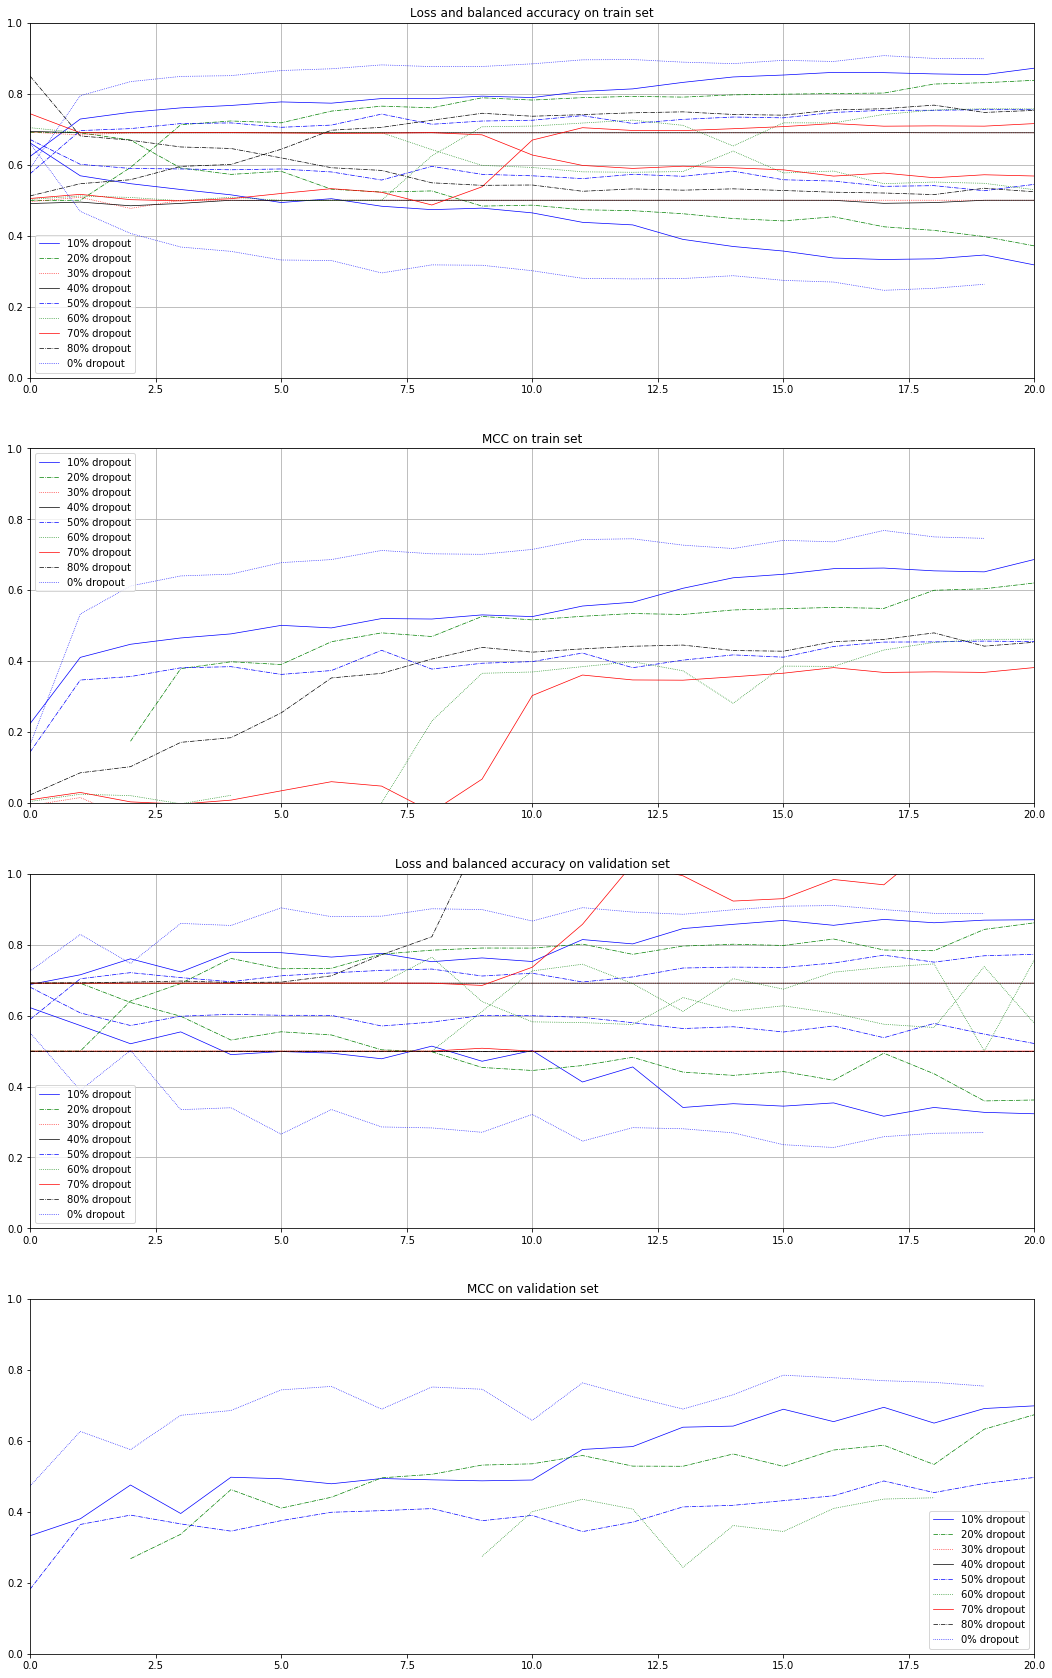

In [223]:
dropouts = range(10,90, 10)
stls = ["-","-.",":"]
cols = ["b", "g", "r", "k"]
basic_metrics_train = ["tp", "tn", "fp", "fn"]
basic_metrics_val=["val_tp", "val_tn", "val_fp", "val_fn"]
fig, ax = plt.subplots(4,1, figsize=(18,30))

for i, dropout in enumerate(dropouts):
    df = pd.read_csv(result_folder+"dropout_nobatchnorm_"+str(dropout)+".csv")
    label = str(dropout)+"% dropout"
    col = cols[i%(len(cols))]
    stl = stls[i%len(stls)]
    df["mcc"]=mcc_df(df.loc[:,basic_metrics_train])
    df["bal_acc"]=weighted_accuracy_df(df.loc[:,basic_metrics_train])
    df["val_mcc"]=mcc_df_series(df.iloc[:,[11,12,13,14]])
    df["val_bal_acc"]=weighted_accuracy_df_series(df.iloc[:,[11,12,13,14]])
    ax[0].plot(df.loss, color=col, linestyle=stl, label=label)
    ax[0].plot(df.bal_acc, color=col, linestyle=stl)
    ax[1].plot(df.mcc, color=col, linestyle=stl, label=label)
    ax[2].plot(df.val_loss, color=col, linestyle=stl, label=label)
    ax[2].plot(df.val_bal_acc, color=col, linestyle=stl)
    ax[3].plot(df.val_mcc, color=col, linestyle=stl, label=label)
    
df = pd.read_csv(result_folder+"dense_size_2ndpass_40.csv")
label = "0% dropout"
col = cols[len(dropouts)%(len(cols))]
stl = stls[len(dropouts)%len(stls)]
df["mcc"]=mcc_df(df.loc[:,basic_metrics_train])
df["bal_acc"]=weighted_accuracy_df(df.loc[:,basic_metrics_train])
df["val_mcc"]=mcc_df_series(df.iloc[:,[11,12,13,14]])
df["val_bal_acc"]=weighted_accuracy_df_series(df.iloc[:,[11,12,13,14]])
ax[0].plot(df.loss, color=col, linestyle=stl, label=label)
ax[0].plot(df.bal_acc, color=col, linestyle=stl)
ax[1].plot(df.mcc, color=col, linestyle=stl, label=label)
ax[2].plot(df.val_loss, color=col, linestyle=stl, label=label)
ax[2].plot(df.val_bal_acc, color=col, linestyle=stl)
ax[3].plot(df.val_mcc, color=col, linestyle=stl, label=label)


titles = ["Loss and balanced accuracy on train set",
         "MCC on train set",
         "Loss and balanced accuracy on validation set",
         "MCC on validation set"]
for i in range(4):
    ax[i].axis([0,20,0,1])
    ax[i].legend()
    ax[i].set_title(titles[i])
    ax[i].grid()
plt.grid()
plt.show()

Here again, no dropout is better. We won't use dropout in the final model.

[Go back to the top](#start)

## Finalizing the model <a name="final"></a>

### Fitting <a name="fit"></a>

Here is a resume of the optimal model's parameters we came with, so far :
    - 1 Augmented images with noise
    - 2 6 subsampling blocks
    - 3 Filters size starting at 24
    - 4 Dense layer of size 40
    - 5 No dropout
    - 6 Batch Normalization unknown.
    
We still need to know if batch normalization optimizes our model. We will make two models and compare them to the original model to see which one is better.

For this step, we make 100 epochs models.

In [224]:
read_log("final")

Model: "sequential_22"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


conv2d_189 (Conv2D)          (None, 224, 224, 40)      400       

_________________________________________________________________

max_pooling2d_68 (MaxPooling (None, 112, 112, 40)      0         

_________________________________________________________________

conv2d_190 (Conv2D)          (None, 112, 112, 80)      28880     

_________________________________________________________________

max_pooling2d_69 (MaxPooling (None, 56, 56, 80)        0         

_________________________________________________________________

conv2d_191 (Conv2D)          (None, 56, 56, 120)       86520     

_________________________________________________________________

max_pooling2d_70 (MaxPooling (None, 28, 28, 120)       0         

_________________________________________________________________

conv2d_192 (Conv2D)          (None, 2

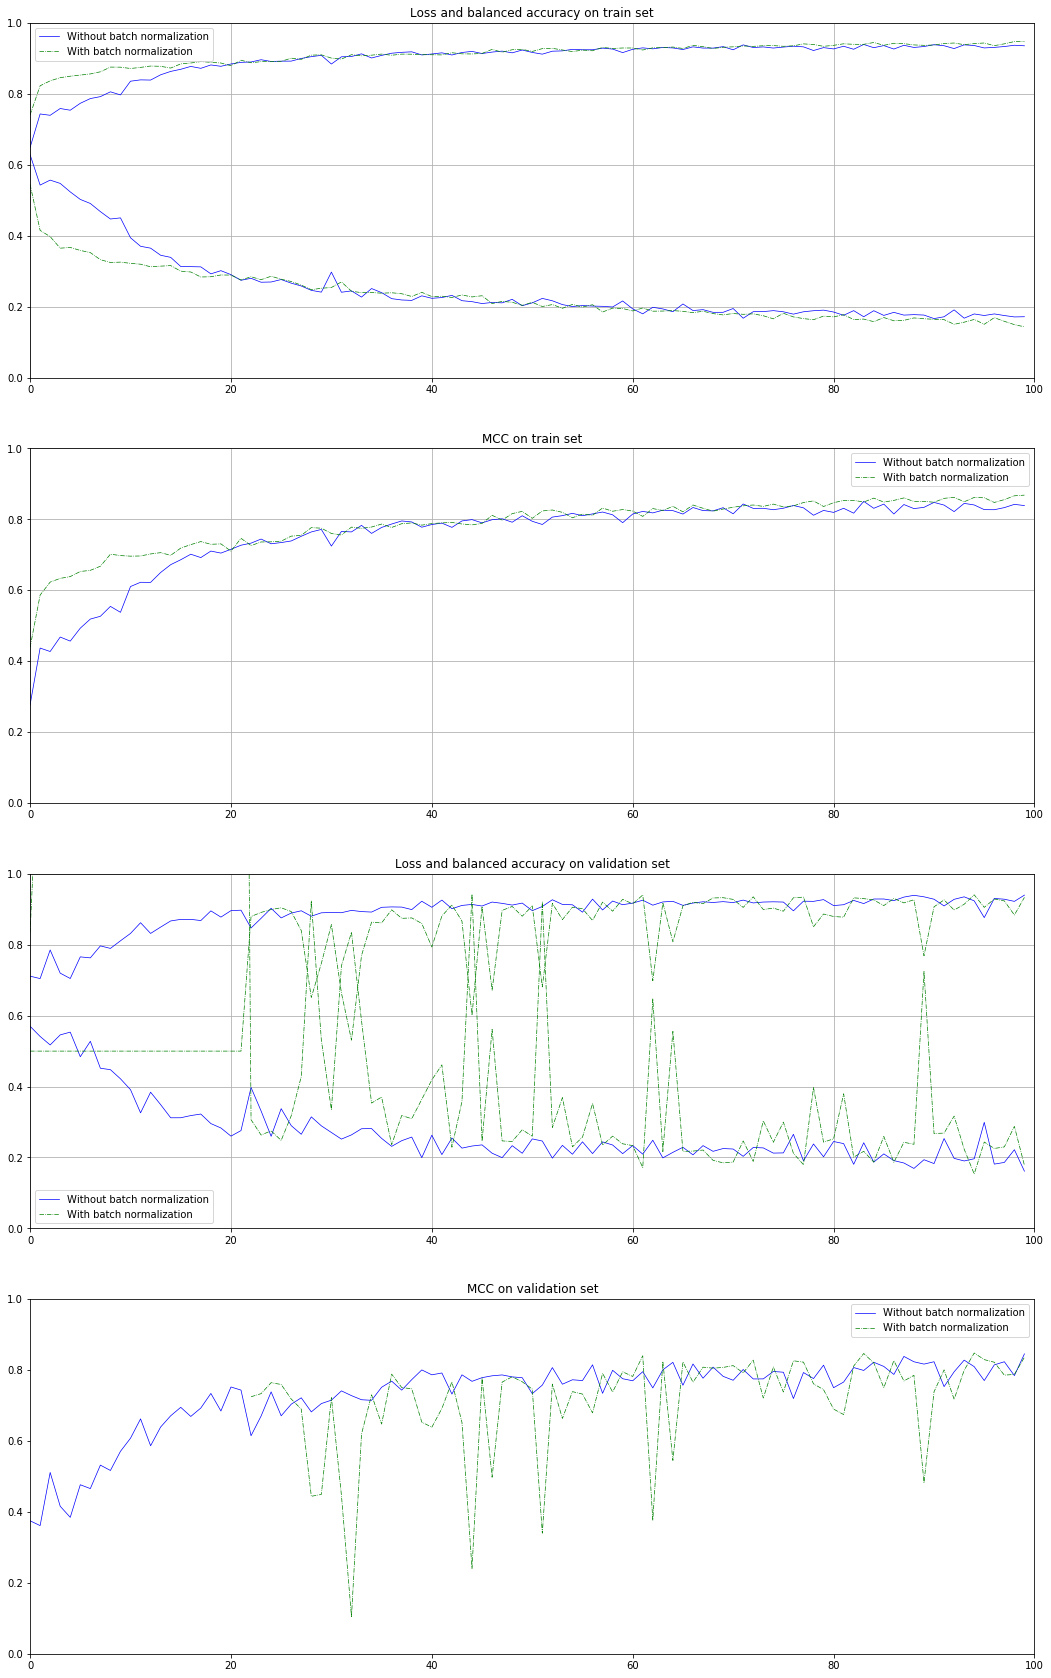

In [225]:
batch_norms = [False, True]
stls = ["-","-.",":"]
cols = ["b", "g", "r", "k"]
basic_metrics_train = ["tp", "tn", "fp", "fn"]
basic_metrics_val=["val_tp", "val_tn", "val_fp", "val_fn"]
fig, ax = plt.subplots(4,1, figsize=(18,30))

for batch_norm in batch_norms:
    df = pd.read_csv(result_folder+"final%s"%("_batchnorm" if batch_norm is True else "")+".csv")
    label = "With%s batch normalization"%("" if batch_norm else "out")
    col = cols[batch_norm]
    stl = stls[batch_norm]
    df["mcc"]=mcc_df(df.loc[:,basic_metrics_train])
    df["bal_acc"]=weighted_accuracy_df(df.loc[:,basic_metrics_train])
    df["val_mcc"]=mcc_df_series(df.iloc[:,[11,12,13,14]])
    df["val_bal_acc"]=weighted_accuracy_df_series(df.iloc[:,[11,12,13,14]])
    ax[0].plot(df.loss, color=col, linestyle=stl, label=label)
    ax[0].plot(df.bal_acc, color=col, linestyle=stl)
    ax[1].plot(df.mcc, color=col, linestyle=stl, label=label)
    ax[2].plot(df.val_loss, color=col, linestyle=stl, label=label)
    ax[2].plot(df.val_bal_acc, color=col, linestyle=stl)
    ax[3].plot(df.val_mcc, color=col, linestyle=stl, label=label)
    
titles = ["Loss and balanced accuracy on train set",
         "MCC on train set",
         "Loss and balanced accuracy on validation set",
         "MCC on validation set"]
for i in range(4):
    ax[i].axis([0,100,0,1])
    ax[i].legend()
    ax[i].set_title(titles[i])
    ax[i].grid()
plt.grid()
plt.show()

The batch_normalized model really shows inconsistent result throughout the validation, but in the end it gives quite similar results. It is not reliable though.

The final model won't have Batch normalization, instead it will use Max Pooling.

[Go back to the top](#start)

### Testing the model on test set <a name="test"></a>

Reminding that the test set is unknow from the model and that it doesn't show any augmentation nor noise, we can test it in real world conditions and truly see how reliable it is.

Let's first try the model we started with, so we know which figures we are coming from :

In [226]:
y_test = list(data_test.infected=="True")

In [227]:
def get_basic_metrics(y_true, y_pred):
    """Compares the results of two boolean lists
    and returns a tuple (TP, TN, FP, FN)"""
    tp=0
    tn=0
    fp=0
    fn=0
    for i, ans in enumerate(y_pred):
        if ans is True:    
            if y_true[i] is True:
                tp+=1
            else:
                fp+=1
        else:
            if y_true[i] is False:
                tn+=1
            else:
                fn+=1
    return (tp, tn, fp, fn)
                
def get_result(model_names):
    if isinstance(model_names, str):
        model_names=[model_names]
    results = {}
    for model_name in model_names :
        model = tf.keras.models.load_model("models\\"+model_name)
        pred = model.predict(test_generator)
        y_pred = []
        for value in pred:
            if value>=0.5:
                y_pred.append(True)
            else:
                y_pred.append(False)
        
        tp, tn, fp, fn = get_basic_metrics(y_test, y_pred)
        
        results[model_name] = {"TP":tp, "TN":tn, "FP":fp, "FN":fn,
        "Accuracy score":accuracy_score(y_test, y_pred),
        "MCC":mcc(tp, tn, fp, fn),
        "Balanced accuracy score":weighted_accuracy(tp, tn, fp, fn),
        "answer":y_pred}
    return results

In [228]:
get_result("model_basic01_weighted_noised")

{'model_basic01_weighted_noised': {'TP': 575,
  'TN': 223,
  'FP': 7,
  'FN': 81,
  'Accuracy score': 0.9006772009029346,
  'MCC': 0.7813289465682066,
  'Balanced accuracy score': 0.9230448038176033,
  'answer': [True,
   True,
   False,
   False,
   True,
   True,
   True,
   True,
   True,
   True,
   False,
   False,
   True,
   True,
   False,
   True,
   False,
   True,
   True,
   False,
   True,
   False,
   False,
   True,
   True,
   False,
   False,
   False,
   False,
   True,
   False,
   False,
   False,
   True,
   False,
   False,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   False,
   True,
   True,
   True,
   True,
   True,
   True,
   False,
   False,
   False,
   True,
   False,
   True,
   False,
   True,
   False,
   True,
   False,
   True,
   False,
   True,
   True,
   True,
   False,
   False,
   False,
   True,
   False,
   False,
   True,
   True,
   True,
   False,
   False,
   True,
   False,
   False,
   True,
   True,
   True,
   True

Let's now see our optimal  model.

In [229]:
get_result("final")

{'final': {'TP': 618,
  'TN': 222,
  'FP': 8,
  'FN': 38,
  'Accuracy score': 0.9480812641083521,
  'MCC': 0.8735512516443696,
  'Balanced accuracy score': 0.9536452810180276,
  'answer': [True,
   True,
   False,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   False,
   False,
   True,
   True,
   False,
   True,
   False,
   True,
   True,
   False,
   True,
   False,
   False,
   True,
   True,
   True,
   False,
   False,
   False,
   True,
   False,
   True,
   True,
   True,
   False,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   False,
   True,
   True,
   True,
   True,
   True,
   True,
   False,
   False,
   False,
   True,
   False,
   True,
   False,
   True,
   False,
   True,
   False,
   True,
   False,
   True,
   True,
   True,
   True,
   False,
   False,
   True,
   False,
   True,
   True,
   True,
   True,
   False,
   True,
   True,
   False,
   False,
   True,
   True,
   True,
   True,
   True,
   False,
   True,
  

This is a much better score, giving evidence that our methodoly is going the good way.

[Go back to the top](#start)

# Ensembling <a name="ensemble"></a>

As you might have noticed, I saved all the test models. Thanks to this, I can make an ensemble of models and check if it gives better results.

On another note, it might be more interesting to have an ensemble composed only with several models based on the optimal architecture we came up with.

We will do both and compare the two.

## Ensemble of disparate models <a name="ensemble_1"></a>

We will get the best top half models of each individual test.

In [230]:
model_saves = ["model_basic01_weighted",
"model_basic01_weighted_noised",
"subsampling_6",
"subsampling_5",
"subsampling_4",
"subsampling_3",
"kernel_2",
"kernel_3",
"kernel_4",
"filter_size_8",
"filter_size_16",
"filter_size_24",
"filter_size_32",
"dense_16",
"dense_32",
"dense_64",
"dense_128",
"dense_256",
"dense_512",
"dense_2ndpass_40",
"dense_2ndpass_60",
"dense_2ndpass_56",
"dense_2ndpass_36",
"dense_2ndpass_52",
"dense_2ndpass_20",
"final",
"final_batchnorm"]

In [231]:
results = get_result(model_saves)

In [232]:
results

{'model_basic01_weighted': {'TP': 575,
  'TN': 223,
  'FP': 7,
  'FN': 81,
  'Accuracy score': 0.9006772009029346,
  'MCC': 0.7813289465682066,
  'Balanced accuracy score': 0.9230448038176033,
  'answer': [True,
   True,
   False,
   False,
   True,
   True,
   True,
   True,
   True,
   True,
   False,
   False,
   True,
   True,
   False,
   True,
   False,
   True,
   True,
   False,
   True,
   False,
   False,
   True,
   True,
   False,
   False,
   False,
   False,
   True,
   False,
   False,
   False,
   True,
   False,
   False,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   False,
   True,
   True,
   True,
   True,
   True,
   True,
   False,
   False,
   False,
   True,
   False,
   True,
   False,
   True,
   False,
   True,
   False,
   True,
   False,
   True,
   True,
   True,
   False,
   False,
   False,
   True,
   False,
   False,
   True,
   True,
   True,
   False,
   False,
   True,
   False,
   False,
   True,
   True,
   True,
   True,
   Tr

Since we are in the binary wolrd (True or False on a single target variable), to get the answer of the ensemble for the each patient,  we can simply take the mean of the answers (which can only be 1 or 0).

In [233]:
ensemble_answer = np.zeros(len(data_test))
for res in results.values():
    ensemble_answer += np.array(res["answer"])
ensemble_answer/=len(model_saves)
ensemble_answer = [True if x>=0.5 else False for x in ensemble_answer]

In [234]:
tp, tn, fp, fn = get_basic_metrics(y_test, ensemble_answer)
print("TP = %i, TN = %i, FP = %i, FN = %i\nAccuracy = %f\nMCC = %f\nBalanced Accuracy = %f"%(tp, tn, fp, fn,(tp+tn)/(tp+tn+fp+fn),
                                                         mcc(tp, tn, fp, fn), weighted_accuracy(tp, tn, fp, fn)))

TP = 603, TN = 222, FP = 8, FN = 53
Accuracy = 0.931151
MCC = 0.838088
Balanced Accuracy = 0.942212


We got a much lower score. Let's try to train several "optimal" models.

[Go back to the top](#start)

## Ensemble of final models <a name="ensemble_2"></a>

In [235]:
read_log("finals")



Final model # 1 / 5 is already ready.

Model: "sequential_1"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


conv2d_3 (Conv2D)            (None, 224, 224, 40)      400       

_________________________________________________________________

max_pooling2d_2 (MaxPooling2 (None, 112, 112, 40)      0         

_________________________________________________________________

conv2d_4 (Conv2D)            (None, 112, 112, 80)      28880     

_________________________________________________________________

max_pooling2d_3 (MaxPooling2 (None, 56, 56, 80)        0         

_________________________________________________________________

conv2d_5 (Conv2D)            (None, 56, 56, 120)       86520     

_________________________________________________________________

max_pooling2d_4 (MaxPooling2 (None, 28, 28, 120)       0         

________________________________________________________________

In [236]:
results = get_result(["final"]+["final_%i"%i for i in range(2,6)])

In [237]:
final_ensemble_answer = np.zeros(len(data_test))
for res in results.values():
    final_ensemble_answer += np.array(res["answer"])
final_ensemble_answer /= 5
final_ensemble_answer = [True if x>=0.5 else False for x in final_ensemble_answer]

In [238]:
final_ensemble_res = get_basic_metrics(y_test, final_ensemble_answer)
tp, tn, fp, fn = final_ensemble_res
print("TP = %i, TN = %i, FP = %i, FN = %i\nAccuracy = %f\nMCC = %f\nBalanced Accuracy = %f"%(tp, tn, fp, fn,(tp+tn)/(tp+tn+fp+fn),
                                                         mcc(*final_ensemble_res), weighted_accuracy(*final_ensemble_res)))

TP = 612, TN = 225, FP = 5, FN = 44
Accuracy = 0.944695
MCC = 0.868770
Balanced Accuracy = 0.955594


We got a lower result. It seems we were lucky for the first "fiunal" model as it get better score than any of the 4 we just created here.

But something else is necessary to explain why this score is so low. It might be because the similarity of their answer is high. Let's check it out.

In [239]:
final_ensemble_answer_df = pd.DataFrame({c:results[c]["answer"] for c in results.keys()})

In [240]:
final_ensemble_answer_df.corr()

final   final_2   final_3   final_4   final_5
final    1.000000  0.883595  0.894791  0.883698  0.898807
final_2  0.883595  1.000000  0.892762  0.864779  0.887718
final_3  0.894791  0.892762  1.000000  0.902701  0.905579
final_4  0.883698  0.864779  0.902701  1.000000  0.874950
final_5  0.898807  0.887718  0.905579  0.874950  1.000000

    . final is very correlated with final_5.
    . final_2 and final_3 are highly correlated.
    . The lone wolf is final_4.

We can then take the best of each of those three groups and try again with only an ensemble of 3.

In [241]:
pd.DataFrame(results).iloc[:-1,:].sort_values(by="Balanced accuracy score", ascending=False, axis=1)

final   final_5   final_3   final_4   final_2
TP                            618       607       601       612       587
TN                            222       225       225       221       227
FP                              8         5         5         9         3
FN                             38        49        55        44        69
Accuracy score           0.948081  0.939052   0.93228  0.940181  0.918736
MCC                      0.873551  0.857086  0.843416  0.855826  0.819598
Balanced accuracy score  0.953645  0.951783   0.94721  0.946898  0.940887

It means we will keep :
    - final
    - final_3
    _ final_4.

In [242]:
final_3_answer = np.zeros(len(data_test))
for model in ["final", "final_3", "final_4"]:
    final_3_answer += np.array(results[model]["answer"])
final_3_answer /= 3
final_3_answer = [True if x>=0.5 else False for x in final_3_answer]
tp, tn, fp, fn = get_basic_metrics(y_test, final_3_answer)
print("TP = %i, TN = %i, FP = %i, FN = %i\nAccuracy = %f\nMCC = %f\nBalanced Accuracy = %f"%(tp, tn, fp, fn,(tp+tn)/(tp+tn+fp+fn),
                                                         mcc(tp, tn, fp, fn), weighted_accuracy(tp, tn, fp, fn)))

TP = 616, TN = 225, FP = 5, FN = 40
Accuracy = 0.949210
MCC = 0.878317
Balanced Accuracy = 0.958643


Once again, the score we got from the hard voting gave us worse results than the best model we got.

Let's try another way to take advantage of hard voting and our five models.

We can try  every combinations of three models. It's a "brute force" way but since we already have each model's results, it won't take much computation.

In [243]:
model_combs = list(itertools.combinations(["final" +("_%i"%i if i>1 else "") for i in range(1,6)], 3))
# model_combs.remove(("final","final_3","final_4"))
model_combs

[('final', 'final_2', 'final_3'),
 ('final', 'final_2', 'final_4'),
 ('final', 'final_2', 'final_5'),
 ('final', 'final_3', 'final_4'),
 ('final', 'final_3', 'final_5'),
 ('final', 'final_4', 'final_5'),
 ('final_2', 'final_3', 'final_4'),
 ('final_2', 'final_3', 'final_5'),
 ('final_2', 'final_4', 'final_5'),
 ('final_3', 'final_4', 'final_5')]

In [244]:
comb_models_res = {}
for comb in model_combs:
    final_3_answer = np.zeros(len(data_test))
    for model in comb :
        final_3_answer += np.array(results[model]["answer"])
    final_3_answer /= 3
    final_3_answer = [True if x>=0.5 else False for x in final_3_answer]
    tp, tn, fp, fn = get_basic_metrics(y_test, final_3_answer)
    comb_models_res[",".join(comb)]={"TP":tp, "TN" : tn, "FP" : fp, "FN" : fn, "Accuracy score":(tp+tn)/(tp+tn+fp+fn),
                                                                                  "MCC" : mcc(tp, tn, fp, fn),
                                                                                  "Balanced accuracy score" : weighted_accuracy(tp, tn, fp, fn)}

pd.concat([pd.DataFrame(comb_models_res), pd.DataFrame(results).iloc[:-1,:]], axis=1).sort_values(by="Balanced accuracy score",axis=1, ascending=False)

final,final_4,final_5  final,final_3,final_4  \
TP                                  622.000000             616.000000   
TN                                  225.000000             225.000000   
FP                                    5.000000               5.000000   
FN                                   34.000000              40.000000   
Accuracy score                        0.955982               0.949210   
MCC                                   0.892988               0.878317   
Balanced accuracy score               0.963216               0.958643   

                         final_2,final_4,final_5  final,final_2,final_4  \
TP                                    610.000000             612.000000   
TN                                    227.000000             226.000000   
FP                                      3.000000               4.000000   
FN                                     46.000000              44.000000   
Accuracy score                          0.944695               0.945824   
MCC                                     0.870553               0.872005   
Balanced accuracy score                 0.958417               0.957768   

                         final,final_3,final_5  final,final_2,final_5  \
TP                                  614.000000             610.000000   
TN                                  225.000000             226.000000   
FP                                    5.000000               4.000000   
FN                                   42.000000              46.000000   
Accuracy score                        0.946953               0.943567   
MCC                                   0.873521               0.867309   
Balanced accuracy score               0.957118               0.956243   

                         final_3,final_4,final_5  final_2,final_3,final_4  \
TP                                    610.000000               607.000000   
TN                                    225.000000               226.000000   
FP                                      5.000000                 4.000000   
FN                                     46.000000                49.000000   
Accuracy score                          0.942438                 0.940181   
MCC                                     0.864064                 0.860346   
Balanced accuracy score                 0.954069                 0.953957   

                            final  final,final_2,final_3   final_5  \
TP                            618             607.000000       607   
TN                            222             225.000000       225   
FP                              8               5.000000         5   
FN                             38              49.000000        49   
Accuracy score           0.948081               0.939052  0.939052   
MCC                      0.873551               0.857086  0.857086   
Balanced accuracy score  0.953645               0.951783  0.951783   

                         final_2,final_3,final_5   final_3   final_4   final_2  
TP                                    603.000000       601       612       587  
TN                                    226.000000       225       221       227  
FP                                      4.000000         5         9         3  
FN                                     53.000000        55        44        69  
Accuracy score                          0.935666   0.93228  0.940181  0.918736  
MCC                                     0.851211  0.843416  0.855826  0.819598  
Balanced accuracy score                 0.950908   0.94721  0.946898  0.940887

Obviously, all scores are acceptable, relatively to the best score we got so far.

The combination final - final_4 - final_5 finally gives better results with 95.7% balanced accuracy but is still lower than our "lucky" solo final model.

[Go back to the top](#start)

# Conclusion <a name="conclusion"></a>

Going from a basic "copy paste from the web" to a specific model, we went from 90.7% to 95.7% balanced accuracy.

Indeed, the dataset we conducted this work on is not ideal to obtain very accurate predictions, but that is beside the point. We can still imagine the benefits of such a methodology on even less predictable datasets. 

Let's sum up :
    - 1 A rigorous methodology will help automate the search of an optimal model.
    - 2 The choice of the metrics in accordance to the dataset is essential. MCC and balanced accuracy should be used more often.
    - 3 Putting weights on the classes of our target variable gives better results overall. Further studies should help understand if it is also true with more balanced and more unbalanced datasets, as the current one is only minimally unbalanced.
    - 4 Hard voting is not necessarily a good thing to do. In some configurations, like the one we ended up with, it can lower the recall (here) or the specificity to the extent that it becomes unfavorable to the accuracy. But even with such constraints, a better solution might exist and one should investigate more to get it.

[Go back to the top](#start)